In [1]:
RunningInColab = 'google.colab' in str(get_ipython())
if RunningInColab:
    from google.colab import drive
    drive.mount('/content/drive')

In [2]:
# Imports
from torch.utils.data import Dataset, DataLoader
import os
import torch
import torchaudio
import torchaudio.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torchsummary import summary

from math import ceil
from tqdm import tqdm

import matplotlib.pyplot as plt

In [3]:
# Hyperparameters
TARGET_SAMPLE_RATE = 16000
TARGET_LENGTH_SECONDS = 4
BATCH_SIZE = 128
EPOCHS = 60
LEARNING_RATE = 2.5e-4
WEIGHT_DECAY = 0.0001
NUM_SAMPLES = TARGET_LENGTH_SECONDS * TARGET_SAMPLE_RATE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations
transformations = [
    # transforms.FrequencyMasking(freq_mask_param=FREQ_MASK_PARAM),
    # transforms.TimeMasking(time_mask_param=TIME_MASK_PARAM),
    transforms.MelSpectrogram(
            sample_rate=TARGET_SAMPLE_RATE,
            n_fft = 1024,
            hop_length = 512,
            n_mels = 64
        )
]

In [4]:
class_mapping = {
  "car_horn":1,
  "dog_barking":2,
  "drilling":3,
  "Fart":4,
  "Guitar":5,
  "Gunshot_and_gunfire":6,
  "Hi-hat":7,
  "Knock":8,
  "Laughter":9,
  "Shatter":10,
  "siren":11,
  "Snare_drum":12,
  "Splash_and_splatter":13,
}

class AudioDataset(Dataset):
  def __init__(self,
               data_dir,
               transformations = transformations,
               target_sample_rate = TARGET_SAMPLE_RATE,
               num_samples = NUM_SAMPLES,
               device = device
               ):
    self.data_dir = data_dir
    self.classes = sorted(os.listdir(data_dir))
    self.file_paths = []
    self.targets = []
    self.transformations = transformations
    self.target_sample_rate = target_sample_rate
    self.num_samples = num_samples
    self.device = device

    createMapping = False
    if(len(class_mapping) == 0):createMapping = True

    for i,class_name in enumerate(self.classes):
      class_dir = os.path.join(data_dir,class_name)
      if(createMapping):class_mapping[class_name] = i

      for filename in os.listdir(class_dir):
        filepath = os.path.join(class_dir,filename)
        self.file_paths.append(filepath)
        self.targets.append(class_mapping[class_name])

  def __len__(self):
    return len(self.file_paths)
  def __getitem__(self,idx):
    audio_path = self.file_paths[idx]
    waveform, sample_rate = torchaudio.load(audio_path)
    waveform = waveform.to(self.device)
    waveform = self._resample_if_necessary(waveform,sample_rate)
    waveform = self._mix_down_if_necessary(waveform)
    waveform = self._cut_if_necessary(waveform)
    waveform = self._right_pad_if_necessary(waveform)


    if self.transformations:
      for transformation in self.transformations:
        waveform = transformation.to(self.device)(waveform)

    # waveform normalisation:
    waveform = torch.log1p(waveform)
    waveform = waveform * 255/(waveform.max() -waveform.min())

    label = self.targets[idx]
    return waveform, label

  def _resample_if_necessary(self, waveform,sample_rate):
    if sample_rate != self.target_sample_rate:
      resampler = torchaudio.transforms.Resample(sample_rate,self.target_sample_rate)
      waveform = resampler.to(self.device)(waveform)
    return waveform

  def _mix_down_if_necessary(self,waveform):
    if waveform.shape[0] > 1:
      waveform = torch.mean(waveform,dim = 0,keepdim = True)
    return waveform
#If the video was longer than TARGET_LENGTH_SECONDS, then we are cropping it to that many seconds by removing seconds equally from both the start and the end sides
  def _cut_if_necessary(self,waveform):
    if waveform.shape[1] > self.num_samples:
      mid = (waveform.shape[1] - 1)//2
      nsby2 = self.num_samples//2
      waveform = waveform[:,mid - nsby2 + 1: mid + self.num_samples - nsby2 + 1]
    return waveform

  def _right_pad_if_necessary(self,waveform):
    num_samples = waveform.shape[1]
    if num_samples < self.num_samples:
      num_missing_samples = self.num_samples - num_samples
      last_dim_padding = (0,num_missing_samples)
      waveform = torch.nn.functional.pad(waveform,last_dim_padding)
    return waveform
  # Define data directories
train_dir: str
val_dir:str
if RunningInColab:
    train_dir = "/content/drive/MyDrive/audio_dataset/train"
    val_dir = "/content/drive/MyDrive/audio_dataset/val"
else:
    train_dir = "audio_dataset/train"
    val_dir = "audio_dataset/val"

train_dataset = AudioDataset(train_dir)
val_dataset = AudioDataset(val_dir)

train_loader = DataLoader(
    train_dataset,batch_size = BATCH_SIZE, shuffle = True
)
val_loader = DataLoader(
    val_dataset,batch_size = BATCH_SIZE
)

In [5]:

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchaudio.transforms as audio_transforms
import torchaudio
import os
class AlexAudio(nn.Module):
    def __init__(self, num_classes):
        super(AlexAudio, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlexAudio(13).to(device)
summary(model, (1, 64, 126))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 15, 30]           7,808
              ReLU-2           [-1, 64, 15, 30]               0
         MaxPool2d-3            [-1, 64, 7, 14]               0
            Conv2d-4           [-1, 192, 7, 14]         307,392
              ReLU-5           [-1, 192, 7, 14]               0
         MaxPool2d-6            [-1, 192, 3, 6]               0
            Conv2d-7            [-1, 384, 3, 6]         663,936
              ReLU-8            [-1, 384, 3, 6]               0
            Conv2d-9            [-1, 256, 3, 6]         884,992
             ReLU-10            [-1, 256, 3, 6]               0
           Conv2d-11            [-1, 256, 3, 6]         590,080
             ReLU-12            [-1, 256, 3, 6]               0
        MaxPool2d-13            [-1, 256, 1, 2]               0
AdaptiveAvgPool2d-14            [-1, 25

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = LEARNING_RATE,weight_decay=WEIGHT_DECAY)


def train_model(model, train_loader, criterion, optimizer, epoch):
  model.train()  # Set model to training mode
  running_loss = 0.0

  correct = 0
  total = len(train_dataset)

  num_classes = len(class_mapping)
  classwise_true_positive = torch.tensor([0]*num_classes).to(device)
  classwise_true_negative = torch.tensor([0]*num_classes).to(device)
  classwise_false_positive = torch.tensor([0]*num_classes).to(device)
  classwise_false_negative = torch.tensor([0]*num_classes).to(device)

  batch_itr = 0
  loop = tqdm(train_loader, leave=True, desc=f"Training Epoch {epoch+1}/{EPOCHS}",bar_format="{l_bar}{bar}|")

  for inputs, labels in train_loader:
    batch_itr+=1

    inputs = inputs.to(device)
    labels = labels.to(device) - torch.ones_like(labels).to(device)

    optimizer.zero_grad()

    # Forward pass
    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)

    loss = criterion(outputs, labels)

    correct += (predicted == labels).sum().item()

    for _,class_number in class_mapping.items():
      classwise_predicted = (predicted == (class_number-1))
      classwise_labels = (labels == (class_number-1))
      classwise_true_positive[class_number-1] += torch.logical_and((classwise_predicted == classwise_labels),(classwise_predicted == 1)).sum().item()
      classwise_true_negative[class_number-1] += torch.logical_and((classwise_predicted == classwise_labels),(classwise_predicted == 0)).sum().item()
      classwise_false_positive[class_number-1] += torch.logical_and((classwise_predicted != classwise_labels),(classwise_predicted == 1)).sum().item()
      classwise_false_negative[class_number-1] += torch.logical_and((classwise_predicted != classwise_labels),(classwise_predicted == 0)).sum().item()


    # Backward pass and optimize
    loss.backward()
    optimizer.step()

    running_loss += loss.item() * inputs.size(0)
    loop.update()

  loop.close()

  # will have to print classwise precision accuracy and recall as well here

  epoch_loss = running_loss / len(train_loader.dataset)

  classwise_train_accuracy = (classwise_true_positive + classwise_true_negative)/(classwise_true_positive + classwise_true_negative + classwise_false_positive + classwise_false_negative)
  classwise_train_precision = (classwise_true_positive)/(classwise_true_positive + classwise_false_positive)
  classwise_train_recall = (classwise_true_positive)/(classwise_true_positive + classwise_false_negative)

  train_accuracy = correct / total
  train_precision = torch.mean(classwise_train_precision).item()
  train_recall = torch.mean(classwise_train_recall).item()

  classwise_train_accuracy = [round(element, 4) for element in classwise_train_accuracy.tolist()]
  classwise_train_precision = [round(element, 4) for element in classwise_train_precision.tolist()]
  classwise_train_recall = [round(element, 4) for element in classwise_train_recall.tolist()]

  print(f"Epoch [{epoch+1}/{EPOCHS}], Training Loss: {epoch_loss:.4f}")
  print(f'Training Accuracy: {train_accuracy:.4f}')
  print(f'Training Precision: {train_precision:.4f}')
  print(f'Training Recall: {train_recall:.4f}')
  print(f'Classwise Training Accuracy: {classwise_train_accuracy}')
  print(f'Classwise Training Precision: {classwise_train_precision}')
  print(f'Classwise Training Recall: {classwise_train_recall}\n')

  return train_accuracy,epoch_loss,train_precision,train_recall

# Validation function
def validate_model(model, val_loader):
  model.eval()  # Set model to evaluation mode
  running_loss = 0.0

  correct = 0
  total = len(val_dataset)

  num_classes = len(class_mapping)
  classwise_true_positive = torch.tensor([0]*num_classes).to(device)
  classwise_true_negative = torch.tensor([0]*num_classes).to(device)
  classwise_false_positive = torch.tensor([0]*num_classes).to(device)
  classwise_false_negative = torch.tensor([0]*num_classes).to(device)

  batch_itr = 0
  loop = tqdm(val_loader, leave=True, desc=f"Validation:",bar_format="{l_bar}{bar}|")

  with torch.no_grad():
    for inputs, labels in val_loader:
      batch_itr+=1

      inputs = inputs.to(device)
      labels = labels.to(device) - torch.ones_like(labels).to(device)
      outputs = model(inputs)
      _, predicted = torch.max(outputs, 1)

      loss = criterion(outputs, labels)

      correct += (predicted == labels).sum().item()

      for _,class_number in class_mapping.items():
        classwise_predicted = (predicted == (class_number-1))
        classwise_labels = (labels == (class_number-1))
        classwise_true_positive[class_number-1] += torch.logical_and((classwise_predicted == classwise_labels),(classwise_predicted == 1)).sum().item()
        classwise_true_negative[class_number-1] += torch.logical_and((classwise_predicted == classwise_labels),(classwise_predicted == 0)).sum().item()
        classwise_false_positive[class_number-1] += torch.logical_and((classwise_predicted != classwise_labels),(classwise_predicted == 1)).sum().item()
        classwise_false_negative[class_number-1] += torch.logical_and((classwise_predicted != classwise_labels),(classwise_predicted == 0)).sum().item()



      running_loss += loss.item() * inputs.size(0)
      loop.update()

  loop.close()

  # will have to print classwise precision accuracy and recall as well here

  epoch_loss = running_loss / len(val_loader.dataset)
  print(f"Validation Loss: {epoch_loss:.4f}")

  classwise_val_accuracy = (classwise_true_positive + classwise_true_negative)/(classwise_true_positive + classwise_true_negative + classwise_false_positive + classwise_false_negative)
  classwise_val_precision = (classwise_true_positive)/(classwise_true_positive + classwise_false_positive)
  classwise_val_recall = (classwise_true_positive)/(classwise_true_positive + classwise_false_negative)

  val_accuracy = correct / total
  val_precision = torch.mean(classwise_val_precision).item()
  val_recall = torch.mean(classwise_val_recall).item()

  classwise_val_accuracy = [round(element, 4) for element in classwise_val_accuracy.tolist()]
  classwise_val_precision = [round(element, 4) for element in classwise_val_precision.tolist()]
  classwise_val_recall = [round(element, 4) for element in classwise_val_recall.tolist()]

  print(f'Validation Accuracy: {val_accuracy:.4f}')
  print(f'Validation Precision: {val_precision:.4f}')
  print(f'Validation Recall: {val_recall:.4f}')
  print(f'Classwise Validation Accuracy: {classwise_val_accuracy}')
  print(f'Classwise Validation Precision: {classwise_val_precision}')
  print(f'Classwise Validation Recall: {classwise_val_recall}\n')

  return val_accuracy,epoch_loss,val_precision,val_recall

In [7]:
# Training Loop
best_accuracy = 0.0

train_accuracy_list=[]
train_loss_list=[]
train_precision_list=[]
train_recall_list=[]
val_accuracy_list=[]
val_loss_list=[]
val_precision_list=[]
val_recall_list=[]

for epoch in range(EPOCHS):
  train_acc,train_loss,train_prec,train_rec = train_model(model,train_loader,criterion,optimizer,epoch)
  train_accuracy_list.append(train_acc)
  train_loss_list.append(train_loss)
  train_precision_list.append(train_prec)
  train_recall_list.append(train_rec)

  val_acc,val_loss,val_prec,val_rec = validate_model(model, val_loader)
  val_accuracy_list.append(val_acc)
  val_loss_list.append(val_loss)
  val_precision_list.append(val_prec)
  val_recall_list.append(val_rec)

  if((epoch+1) % 10 == 0 or (epoch+1) == EPOCHS):
    filename = f"epoch{epoch+1}_{val_acc * 100:.2f}"
    torch.save(model.state_dict(),os.path.join("model2_every10epochs",filename))
  if val_acc > best_accuracy:best_accuracy = val_acc

  print(f"Best Validation Accuracy: {best_accuracy:.4f}\n")

Training Epoch 1/60: 100%|██████████|


Epoch [1/60], Training Loss: 2.2161
Training Accuracy: 0.2680
Training Precision: 0.1806
Training Recall: 0.1934
Classwise Training Accuracy: [0.8501, 0.8141, 0.8545, 0.9146, 0.8096, 0.7555, 0.9634, 0.9646, 0.9374, 0.9562, 0.8569, 0.8952, 0.964]
Classwise Training Precision: [0.0752, 0.2782, 0.4146, 0.131, 0.2113, 0.1766, 0.1818, 0.0, 0.0909, 0.0, 0.402, 0.3866, 0.0]
Classwise Training Recall: [0.0988, 0.2578, 0.6375, 0.0756, 0.2518, 0.4509, 0.0117, 0.0, 0.0034, 0.0, 0.4946, 0.2321, 0.0]



Validation:: 100%|██████████|


Validation Loss: 1.5951
Validation Accuracy: 0.4830
Validation Precision: nan
Validation Recall: 0.3464
Classwise Validation Accuracy: [0.9297, 0.8519, 0.9082, 0.9173, 0.8246, 0.8379, 0.9653, 0.9661, 0.9396, 0.9562, 0.9545, 0.9504, 0.9644]
Classwise Validation Precision: [nan, 0.4603, 0.57, 0.2812, 0.3021, 0.3056, nan, nan, nan, nan, 0.7972, 0.6757, nan]
Classwise Validation Recall: [0.0, 0.6875, 0.8429, 0.25, 0.4265, 0.5893, 0.0, 0.0, 0.0, 0.0, 0.8143, 0.8929, 0.0]

Best Validation Accuracy: 0.4830



Training Epoch 2/60: 100%|██████████|


Epoch [2/60], Training Loss: 1.4194
Training Accuracy: 0.5305
Training Precision: nan
Training Recall: 0.4099
Classwise Training Accuracy: [0.9257, 0.8738, 0.9236, 0.8893, 0.8681, 0.902, 0.966, 0.9654, 0.9218, 0.9516, 0.9518, 0.9574, 0.9644]
Classwise Training Precision: [0.3651, 0.517, 0.6507, 0.2896, 0.4427, 0.4765, 0.6667, nan, 0.2543, 0.358, 0.7717, 0.7367, nan]
Classwise Training Recall: [0.0669, 0.6406, 0.7286, 0.5842, 0.6551, 0.6339, 0.0702, 0.0, 0.1492, 0.1368, 0.8268, 0.8371, 0.0]



Validation:: 100%|██████████|


Validation Loss: 1.2258
Validation Accuracy: 0.5955
Validation Precision: nan
Validation Recall: 0.4752
Classwise Validation Accuracy: [0.928, 0.9115, 0.9057, 0.9388, 0.8586, 0.9313, 0.9686, 0.9661, 0.9396, 0.9297, 0.9727, 0.976, 0.9644]
Classwise Validation Precision: [0.25, 0.6626, 0.5586, 0.48, 0.4314, 0.5986, 0.75, nan, nan, 0.3644, 0.935, 0.8487, nan]
Classwise Validation Recall: [0.0118, 0.675, 0.8857, 0.3333, 0.8088, 0.7857, 0.1429, 0.0, 0.0, 0.8113, 0.8214, 0.9018, 0.0]

Best Validation Accuracy: 0.5955



Training Epoch 3/60: 100%|██████████|


Epoch [3/60], Training Loss: 1.0182
Training Accuracy: 0.6669
Training Precision: 0.6556
Training Recall: 0.5754
Classwise Training Accuracy: [0.9337, 0.9172, 0.9405, 0.9319, 0.9251, 0.9403, 0.972, 0.9644, 0.9376, 0.9545, 0.9708, 0.9809, 0.965]
Classwise Training Precision: [0.5426, 0.663, 0.7459, 0.451, 0.6341, 0.6531, 0.6378, 0.4627, 0.4851, 0.4802, 0.8591, 0.908, 1.0]
Classwise Training Recall: [0.407, 0.7563, 0.7339, 0.6323, 0.7938, 0.7522, 0.4737, 0.1845, 0.4407, 0.5142, 0.8929, 0.8817, 0.0173]



Validation:: 100%|██████████|


Validation Loss: 0.8534
Validation Accuracy: 0.7270
Validation Precision: 0.6929
Validation Recall: 0.6800
Classwise Validation Accuracy: [0.9537, 0.9355, 0.9388, 0.9438, 0.9471, 0.9636, 0.9843, 0.9694, 0.933, 0.9628, 0.9768, 0.9801, 0.9653]
Classwise Validation Precision: [0.7302, 0.777, 0.6988, 0.5196, 0.7857, 0.8091, 0.7674, 0.5417, 0.4565, 0.6, 0.9179, 0.8793, 0.5238]
Classwise Validation Recall: [0.5412, 0.7188, 0.8286, 0.7361, 0.7279, 0.7946, 0.7857, 0.6341, 0.5753, 0.4528, 0.8786, 0.9107, 0.2558]

Best Validation Accuracy: 0.7270



Training Epoch 4/60: 100%|██████████|


Epoch [4/60], Training Loss: 0.7122
Training Accuracy: 0.7738
Training Precision: 0.7341
Training Recall: 0.7229
Classwise Training Accuracy: [0.9576, 0.945, 0.9564, 0.9496, 0.9652, 0.9607, 0.9819, 0.9796, 0.9549, 0.9658, 0.978, 0.9876, 0.9652]
Classwise Training Precision: [0.6949, 0.7874, 0.8308, 0.5701, 0.8262, 0.7672, 0.7399, 0.7226, 0.6138, 0.6036, 0.9052, 0.9512, 0.5303]
Classwise Training Recall: [0.7151, 0.7984, 0.7804, 0.6426, 0.8759, 0.8237, 0.7485, 0.6667, 0.6949, 0.6321, 0.9036, 0.9129, 0.2023]



Validation:: 100%|██████████|


Validation Loss: 0.7960
Validation Accuracy: 0.7477
Validation Precision: 0.7379
Validation Recall: 0.7132
Classwise Validation Accuracy: [0.9603, 0.9396, 0.9603, 0.962, 0.9454, 0.9644, 0.9785, 0.9785, 0.9264, 0.9677, 0.9661, 0.9851, 0.9611]
Classwise Validation Precision: [0.6637, 0.9394, 0.9107, 0.7241, 0.7011, 0.8966, 0.6739, 0.8571, 0.4385, 0.5946, 0.8075, 0.9519, 0.4333]
Classwise Validation Recall: [0.8824, 0.5813, 0.7286, 0.5833, 0.8971, 0.6964, 0.7381, 0.439, 0.7808, 0.8302, 0.9286, 0.8839, 0.3023]

Best Validation Accuracy: 0.7477



Training Epoch 5/60: 100%|██████████|


Epoch [5/60], Training Loss: 0.5074
Training Accuracy: 0.8399
Training Precision: 0.8107
Training Recall: 0.8082
Classwise Training Accuracy: [0.9718, 0.9648, 0.9654, 0.966, 0.9757, 0.9722, 0.9872, 0.9864, 0.9718, 0.9757, 0.9839, 0.9874, 0.9712]
Classwise Training Precision: [0.809, 0.8788, 0.8643, 0.71, 0.8785, 0.8351, 0.8385, 0.7802, 0.7438, 0.7026, 0.9213, 0.9388, 0.6387]
Classwise Training Recall: [0.7878, 0.85, 0.8304, 0.732, 0.9106, 0.8705, 0.7895, 0.8452, 0.8169, 0.7689, 0.9411, 0.9241, 0.4393]



Validation:: 100%|██████████|


Validation Loss: 0.6107
Validation Accuracy: 0.8255
Validation Precision: 0.7992
Validation Recall: 0.8054
Classwise Validation Accuracy: [0.9735, 0.9495, 0.9711, 0.9677, 0.9677, 0.9744, 0.9826, 0.9868, 0.9644, 0.9744, 0.9793, 0.9835, 0.976]
Classwise Validation Precision: [0.7849, 0.7829, 0.8947, 0.7619, 0.8593, 0.8522, 0.7143, 0.766, 0.7206, 0.7292, 0.9675, 0.9035, 0.6522]
Classwise Validation Recall: [0.8588, 0.8562, 0.85, 0.6667, 0.8529, 0.875, 0.8333, 0.878, 0.6712, 0.6604, 0.85, 0.9196, 0.6977]

Best Validation Accuracy: 0.8255



Training Epoch 6/60: 100%|██████████|


Epoch [6/60], Training Loss: 0.4068
Training Accuracy: 0.8693
Training Precision: 0.8530
Training Recall: 0.8484
Classwise Training Accuracy: [0.978, 0.9685, 0.9683, 0.972, 0.98, 0.9798, 0.9881, 0.9928, 0.978, 0.9823, 0.9835, 0.9881, 0.9792]
Classwise Training Precision: [0.8357, 0.8871, 0.8638, 0.7592, 0.9005, 0.8872, 0.8645, 0.8844, 0.8092, 0.7838, 0.9317, 0.9353, 0.7466]
Classwise Training Recall: [0.8576, 0.8719, 0.8607, 0.7801, 0.9252, 0.8951, 0.7836, 0.9107, 0.8339, 0.8208, 0.925, 0.9353, 0.6301]



Validation:: 100%|██████████|


Validation Loss: 0.7379
Validation Accuracy: 0.7916
Validation Precision: 0.7830
Validation Recall: 0.7802
Classwise Validation Accuracy: [0.9686, 0.9446, 0.9719, 0.9429, 0.9545, 0.9653, 0.9901, 0.9835, 0.957, 0.9752, 0.9785, 0.9843, 0.9669]
Classwise Validation Precision: [0.8052, 0.7853, 0.9077, 0.513, 0.988, 0.7966, 0.9167, 0.8, 0.6105, 0.6494, 0.9524, 0.9189, 0.5349]
Classwise Validation Recall: [0.7294, 0.8, 0.8429, 0.8194, 0.6029, 0.8393, 0.7857, 0.6829, 0.7945, 0.9434, 0.8571, 0.9107, 0.5349]

Best Validation Accuracy: 0.8255



Training Epoch 7/60: 100%|██████████|


Epoch [7/60], Training Loss: 0.3046
Training Accuracy: 0.9030
Training Precision: 0.8880
Training Recall: 0.8832
Classwise Training Accuracy: [0.9848, 0.9767, 0.9817, 0.9784, 0.9835, 0.9844, 0.9903, 0.9961, 0.9821, 0.9854, 0.9918, 0.9899, 0.9811]
Classwise Training Precision: [0.8792, 0.915, 0.9243, 0.8, 0.927, 0.9043, 0.8974, 0.9357, 0.849, 0.8373, 0.9659, 0.9443, 0.7647]
Classwise Training Recall: [0.9099, 0.9078, 0.9161, 0.8522, 0.927, 0.9286, 0.8187, 0.9524, 0.8576, 0.8255, 0.9625, 0.9464, 0.6763]



Validation:: 100%|██████████|


Validation Loss: 0.5176
Validation Accuracy: 0.8511
Validation Precision: 0.8344
Validation Recall: 0.8335
Classwise Validation Accuracy: [0.9793, 0.9578, 0.9793, 0.9694, 0.9744, 0.9777, 0.9892, 0.9892, 0.9711, 0.9785, 0.9777, 0.9876, 0.9711]
Classwise Validation Precision: [0.8571, 0.8516, 0.9197, 0.807, 0.8621, 0.9381, 0.9143, 0.85, 0.7714, 0.68, 0.8792, 0.945, 0.5714]
Classwise Validation Recall: [0.8471, 0.825, 0.9, 0.6389, 0.9191, 0.8125, 0.7619, 0.8293, 0.7397, 0.9623, 0.9357, 0.9196, 0.7442]

Best Validation Accuracy: 0.8511



Training Epoch 8/60: 100%|██████████|


Epoch [8/60], Training Loss: 0.2256
Training Accuracy: 0.9247
Training Precision: 0.9088
Training Recall: 0.9085
Classwise Training Accuracy: [0.9897, 0.985, 0.9856, 0.9837, 0.9926, 0.9848, 0.9911, 0.9944, 0.9872, 0.9876, 0.9922, 0.9895, 0.9858]
Classwise Training Precision: [0.9129, 0.9493, 0.9313, 0.8655, 0.9672, 0.9101, 0.8765, 0.9172, 0.9003, 0.8423, 0.9711, 0.9501, 0.821]
Classwise Training Recall: [0.9448, 0.9359, 0.9446, 0.8625, 0.9672, 0.9263, 0.8713, 0.9226, 0.8881, 0.8821, 0.9607, 0.9353, 0.7688]



Validation:: 100%|██████████|


Validation Loss: 0.6110
Validation Accuracy: 0.8296
Validation Precision: 0.8175
Validation Recall: 0.8069
Classwise Validation Accuracy: [0.9777, 0.9586, 0.9686, 0.9702, 0.9669, 0.9677, 0.9752, 0.9826, 0.9694, 0.9793, 0.9835, 0.9793, 0.9801]
Classwise Validation Precision: [0.8021, 0.9167, 0.925, 0.7727, 0.8, 0.7874, 0.5968, 0.6724, 0.7647, 0.8889, 0.9225, 0.8655, 0.913]
Classwise Validation Recall: [0.9059, 0.7563, 0.7929, 0.7083, 0.9412, 0.8929, 0.881, 0.9512, 0.7123, 0.6038, 0.9357, 0.9196, 0.4884]

Best Validation Accuracy: 0.8511



Training Epoch 9/60: 100%|██████████|


Epoch [9/60], Training Loss: 0.1997
Training Accuracy: 0.9352
Training Precision: 0.9254
Training Recall: 0.9238
Classwise Training Accuracy: [0.9901, 0.9864, 0.9848, 0.9833, 0.9883, 0.9895, 0.9924, 0.9973, 0.9907, 0.9893, 0.9949, 0.993, 0.9903]
Classwise Training Precision: [0.9302, 0.9415, 0.9355, 0.8646, 0.9456, 0.9382, 0.9036, 0.9429, 0.931, 0.8883, 0.9785, 0.9641, 0.8663]
Classwise Training Recall: [0.9302, 0.9563, 0.9321, 0.8557, 0.9507, 0.9487, 0.8772, 0.9821, 0.9153, 0.8632, 0.9768, 0.9598, 0.8613]



Validation:: 100%|██████████|


Validation Loss: 0.5188
Validation Accuracy: 0.8528
Validation Precision: 0.8316
Validation Recall: 0.8326
Classwise Validation Accuracy: [0.9785, 0.9628, 0.9785, 0.9711, 0.9686, 0.9727, 0.9835, 0.9859, 0.9719, 0.9835, 0.9835, 0.9835, 0.9818]
Classwise Validation Precision: [0.8105, 0.9197, 0.913, 0.8246, 0.8267, 0.811, 0.7292, 0.7727, 0.8095, 0.8, 0.9286, 0.8966, 0.7692]
Classwise Validation Recall: [0.9059, 0.7875, 0.9, 0.6528, 0.9118, 0.9196, 0.8333, 0.8293, 0.6986, 0.8302, 0.9286, 0.9286, 0.6977]

Best Validation Accuracy: 0.8528



Training Epoch 10/60: 100%|██████████|


Epoch [10/60], Training Loss: 0.1561
Training Accuracy: 0.9506
Training Precision: 0.9425
Training Recall: 0.9394
Classwise Training Accuracy: [0.9911, 0.9903, 0.9885, 0.9872, 0.9942, 0.9928, 0.9934, 0.9981, 0.9907, 0.992, 0.9961, 0.9944, 0.9922]
Classwise Training Precision: [0.944, 0.9714, 0.9421, 0.8881, 0.9727, 0.9558, 0.9264, 0.9704, 0.9223, 0.91, 0.9822, 0.9626, 0.9042]
Classwise Training Recall: [0.9302, 0.9547, 0.9589, 0.9003, 0.9763, 0.9665, 0.883, 0.9762, 0.9254, 0.9057, 0.9839, 0.9777, 0.8728]



Validation:: 100%|██████████|


Validation Loss: 0.5882
Validation Accuracy: 0.8569
Validation Precision: 0.8486
Validation Recall: 0.8324
Classwise Validation Accuracy: [0.9785, 0.9636, 0.9793, 0.9562, 0.9793, 0.9801, 0.9901, 0.9835, 0.9677, 0.9801, 0.9843, 0.9884, 0.9826]
Classwise Validation Precision: [0.8391, 0.8671, 0.9078, 0.5979, 0.944, 0.9783, 0.875, 0.92, 0.6889, 0.6933, 0.9353, 0.9623, 0.8235]
Classwise Validation Recall: [0.8588, 0.8562, 0.9143, 0.8056, 0.8676, 0.8036, 0.8333, 0.561, 0.8493, 0.9811, 0.9286, 0.9107, 0.6512]

Best Validation Accuracy: 0.8569



Training Epoch 11/60: 100%|██████████|


Epoch [11/60], Training Loss: 0.1159
Training Accuracy: 0.9621
Training Precision: 0.9562
Training Recall: 0.9562
Classwise Training Accuracy: [0.9944, 0.9928, 0.9903, 0.9916, 0.9946, 0.9936, 0.9944, 0.999, 0.994, 0.9938, 0.9959, 0.9949, 0.9949]
Classwise Training Precision: [0.9621, 0.9764, 0.9589, 0.9281, 0.9728, 0.9644, 0.9286, 0.9766, 0.9463, 0.9213, 0.9839, 0.971, 0.9405]
Classwise Training Recall: [0.9593, 0.9688, 0.9571, 0.9313, 0.9799, 0.9665, 0.9123, 0.994, 0.9559, 0.9387, 0.9804, 0.9732, 0.9133]



Validation:: 100%|██████████|


Validation Loss: 0.6203
Validation Accuracy: 0.8594
Validation Precision: 0.8502
Validation Recall: 0.8414
Classwise Validation Accuracy: [0.9818, 0.9479, 0.9768, 0.9677, 0.9801, 0.9859, 0.9892, 0.9884, 0.9661, 0.9826, 0.9843, 0.9851, 0.9826]
Classwise Validation Precision: [0.8987, 0.7389, 0.9242, 0.7463, 0.9746, 0.9524, 0.8919, 0.8462, 0.7105, 0.75, 0.9618, 0.9273, 0.7292]
Classwise Validation Recall: [0.8353, 0.9375, 0.8714, 0.6944, 0.8456, 0.8929, 0.7857, 0.8049, 0.7397, 0.9057, 0.9, 0.9107, 0.814]

Best Validation Accuracy: 0.8594



Training Epoch 12/60: 100%|██████████|


Epoch [12/60], Training Loss: 0.0845
Training Accuracy: 0.9687
Training Precision: 0.9620
Training Recall: 0.9613
Classwise Training Accuracy: [0.9967, 0.9946, 0.994, 0.9928, 0.9951, 0.9957, 0.9942, 0.9973, 0.9949, 0.9957, 0.9969, 0.9942, 0.9953]
Classwise Training Precision: [0.9686, 0.9812, 0.9699, 0.9444, 0.9764, 0.9776, 0.9281, 0.9586, 0.9655, 0.9484, 0.9892, 0.9667, 0.931]
Classwise Training Recall: [0.9855, 0.9781, 0.9786, 0.9347, 0.9799, 0.9754, 0.9064, 0.9643, 0.9492, 0.9528, 0.9839, 0.971, 0.9364]



Validation:: 100%|██████████|


Validation Loss: 0.7511
Validation Accuracy: 0.8321
Validation Precision: 0.8349
Validation Recall: 0.8050
Classwise Validation Accuracy: [0.9719, 0.9446, 0.9644, 0.9711, 0.9711, 0.9777, 0.9868, 0.9884, 0.9636, 0.9785, 0.9835, 0.9826, 0.9801]
Classwise Validation Precision: [0.8228, 0.7204, 0.8489, 0.9111, 0.8915, 0.967, 0.825, 0.9091, 0.6629, 0.7015, 0.9545, 0.8957, 0.7436]
Classwise Validation Recall: [0.7647, 0.95, 0.8429, 0.5694, 0.8456, 0.7857, 0.7857, 0.7317, 0.8082, 0.8868, 0.9, 0.9196, 0.6744]

Best Validation Accuracy: 0.8594



Training Epoch 13/60: 100%|██████████|


Epoch [13/60], Training Loss: 0.1233
Training Accuracy: 0.9599
Training Precision: 0.9530
Training Recall: 0.9534
Classwise Training Accuracy: [0.9951, 0.9903, 0.9934, 0.9909, 0.9957, 0.9932, 0.9942, 0.9967, 0.9936, 0.9949, 0.9942, 0.9924, 0.9951]
Classwise Training Precision: [0.9706, 0.9684, 0.9664, 0.9303, 0.98, 0.9601, 0.9231, 0.9419, 0.9459, 0.9431, 0.97, 0.9639, 0.9257]
Classwise Training Recall: [0.9593, 0.9578, 0.9768, 0.9175, 0.9818, 0.9665, 0.9123, 0.9643, 0.9492, 0.9387, 0.9804, 0.9531, 0.9364]



Validation:: 100%|██████████|


Validation Loss: 0.7973
Validation Accuracy: 0.8238
Validation Precision: 0.8472
Validation Recall: 0.7852
Classwise Validation Accuracy: [0.9793, 0.9338, 0.9735, 0.9644, 0.9793, 0.9752, 0.9901, 0.9876, 0.9413, 0.9818, 0.9793, 0.9851, 0.9768]
Classwise Validation Precision: [0.9412, 0.6786, 0.9426, 0.7302, 0.9744, 0.8596, 0.9412, 0.8611, 0.5077, 0.9189, 0.9675, 0.9123, 0.7778]
Classwise Validation Recall: [0.7529, 0.95, 0.8214, 0.6389, 0.8382, 0.875, 0.7619, 0.7561, 0.9041, 0.6415, 0.85, 0.9286, 0.4884]

Best Validation Accuracy: 0.8594



Training Epoch 14/60: 100%|██████████|


Epoch [14/60], Training Loss: 0.0739
Training Accuracy: 0.9767
Training Precision: 0.9732
Training Recall: 0.9707
Classwise Training Accuracy: [0.9969, 0.9918, 0.9967, 0.9967, 0.9986, 0.9975, 0.994, 0.999, 0.9963, 0.9971, 0.9977, 0.9944, 0.9967]
Classwise Training Precision: [0.9713, 0.9688, 0.9857, 0.9758, 0.9963, 0.9844, 0.9438, 0.988, 0.9663, 0.976, 0.9928, 0.9586, 0.9435]
Classwise Training Recall: [0.9855, 0.9688, 0.9857, 0.9691, 0.9909, 0.9888, 0.883, 0.9821, 0.9729, 0.9575, 0.9875, 0.9821, 0.9653]



Validation:: 100%|██████████|


Validation Loss: 0.6987
Validation Accuracy: 0.8577
Validation Precision: 0.8479
Validation Recall: 0.8356
Classwise Validation Accuracy: [0.9851, 0.9578, 0.9785, 0.9744, 0.9826, 0.9793, 0.9892, 0.9868, 0.9462, 0.9851, 0.9868, 0.9859, 0.9777]
Classwise Validation Precision: [0.9718, 0.8114, 0.9597, 0.8727, 0.9457, 0.885, 0.8222, 0.8049, 0.5364, 0.8723, 0.9306, 0.9358, 0.6739]
Classwise Validation Recall: [0.8118, 0.8875, 0.85, 0.6667, 0.8971, 0.8929, 0.881, 0.8049, 0.8082, 0.7736, 0.9571, 0.9107, 0.7209]

Best Validation Accuracy: 0.8594



Training Epoch 15/60: 100%|██████████|


Epoch [15/60], Training Loss: 0.0628
Training Accuracy: 0.9800
Training Precision: 0.9777
Training Recall: 0.9774
Classwise Training Accuracy: [0.9977, 0.9936, 0.9967, 0.9942, 0.9977, 0.9965, 0.9967, 0.9988, 0.9959, 0.999, 0.9988, 0.9961, 0.9984]
Classwise Training Precision: [0.9798, 0.9795, 0.984, 0.9582, 0.9909, 0.9757, 0.9532, 0.9821, 0.9725, 0.9859, 0.9911, 0.9799, 0.9769]
Classwise Training Recall: [0.9884, 0.9719, 0.9875, 0.945, 0.9891, 0.9866, 0.9532, 0.9821, 0.9593, 0.9906, 0.9982, 0.9777, 0.9769]



Validation:: 100%|██████████|


Validation Loss: 0.8095
Validation Accuracy: 0.8462
Validation Precision: 0.8416
Validation Recall: 0.8305
Classwise Validation Accuracy: [0.9859, 0.9644, 0.9752, 0.9669, 0.981, 0.9777, 0.9892, 0.9892, 0.938, 0.9752, 0.9868, 0.9868, 0.976]
Classwise Validation Precision: [0.8953, 0.9333, 0.8929, 0.82, 0.9748, 0.957, 0.9143, 0.8889, 0.4929, 0.662, 0.9247, 0.9444, 0.64]
Classwise Validation Recall: [0.9059, 0.7875, 0.8929, 0.5694, 0.8529, 0.7946, 0.7619, 0.7805, 0.9452, 0.8868, 0.9643, 0.9107, 0.7442]

Best Validation Accuracy: 0.8594



Training Epoch 16/60: 100%|██████████|


Epoch [16/60], Training Loss: 0.0479
Training Accuracy: 0.9891
Training Precision: 0.9865
Training Recall: 0.9848
Classwise Training Accuracy: [0.9992, 0.9988, 0.999, 0.9975, 0.9977, 0.9988, 0.9965, 0.9996, 0.9977, 0.9992, 0.9998, 0.9967, 0.9977]
Classwise Training Precision: [0.9971, 0.9938, 0.9947, 0.9761, 0.9873, 0.9955, 0.9583, 1.0, 0.9863, 0.986, 0.9982, 0.98, 0.9709]
Classwise Training Recall: [0.9913, 0.9969, 0.9964, 0.9828, 0.9927, 0.9911, 0.9415, 0.9881, 0.9763, 0.9953, 1.0, 0.9844, 0.9653]



Validation:: 100%|██████████|


Validation Loss: 0.6572
Validation Accuracy: 0.8660
Validation Precision: 0.8570
Validation Recall: 0.8436
Classwise Validation Accuracy: [0.9818, 0.9636, 0.9785, 0.9711, 0.9793, 0.9826, 0.9876, 0.9917, 0.9644, 0.9843, 0.9835, 0.9835, 0.9801]
Classwise Validation Precision: [0.8621, 0.8187, 0.913, 0.8936, 0.937, 0.9099, 0.814, 0.9189, 0.6531, 0.8542, 0.9615, 0.9035, 0.7021]
Classwise Validation Recall: [0.8824, 0.9312, 0.9, 0.5833, 0.875, 0.9018, 0.8333, 0.8293, 0.8767, 0.7736, 0.8929, 0.9196, 0.7674]

Best Validation Accuracy: 0.8660



Training Epoch 17/60: 100%|██████████|


Epoch [17/60], Training Loss: 0.0600
Training Accuracy: 0.9837
Training Precision: 0.9795
Training Recall: 0.9791
Classwise Training Accuracy: [0.999, 0.9986, 0.9975, 0.9928, 0.9975, 0.9981, 0.9965, 0.999, 0.9979, 0.9981, 0.9992, 0.9957, 0.9975]
Classwise Training Precision: [0.9913, 0.9938, 0.991, 0.9444, 0.9908, 0.9867, 0.9583, 0.988, 0.9831, 0.981, 0.9964, 0.9734, 0.9548]
Classwise Training Recall: [0.9942, 0.9953, 0.9875, 0.9347, 0.9872, 0.9933, 0.9415, 0.9821, 0.9831, 0.9764, 0.9964, 0.9799, 0.9769]



Validation:: 100%|██████████|


Validation Loss: 0.6134
Validation Accuracy: 0.8619
Validation Precision: 0.8585
Validation Recall: 0.8380
Classwise Validation Accuracy: [0.9884, 0.9677, 0.9777, 0.976, 0.9603, 0.9785, 0.9876, 0.9884, 0.9719, 0.9868, 0.981, 0.9768, 0.9826]
Classwise Validation Precision: [0.8737, 0.9231, 0.9313, 0.8209, 0.7588, 0.9216, 0.8293, 0.814, 0.8197, 0.8491, 0.9034, 0.8231, 0.8929]
Classwise Validation Recall: [0.9765, 0.825, 0.8714, 0.7639, 0.9485, 0.8393, 0.8095, 0.8537, 0.6849, 0.8491, 0.9357, 0.9554, 0.5814]

Best Validation Accuracy: 0.8660



Training Epoch 18/60: 100%|██████████|


Epoch [18/60], Training Loss: 0.0494
Training Accuracy: 0.9862
Training Precision: 0.9853
Training Recall: 0.9837
Classwise Training Accuracy: [0.999, 0.9973, 0.9977, 0.9965, 0.9967, 0.9981, 0.9963, 0.9998, 0.9981, 0.999, 0.9988, 0.9957, 0.9994]
Classwise Training Precision: [0.9913, 0.9906, 0.9893, 0.9724, 0.9854, 0.9911, 0.9636, 1.0, 0.9799, 0.9905, 0.9964, 0.9692, 0.9885]
Classwise Training Recall: [0.9942, 0.9891, 0.9911, 0.9691, 0.9854, 0.9888, 0.9298, 0.994, 0.9898, 0.9858, 0.9929, 0.9844, 0.9942]



Validation:: 100%|██████████|


Validation Loss: 0.6410
Validation Accuracy: 0.8668
Validation Precision: 0.8489
Validation Recall: 0.8468
Classwise Validation Accuracy: [0.981, 0.9727, 0.9744, 0.9702, 0.9768, 0.976, 0.9884, 0.9909, 0.9719, 0.9801, 0.9851, 0.9851, 0.981]
Classwise Validation Precision: [0.837, 0.8802, 0.8759, 0.75, 0.9154, 0.9109, 0.8182, 0.8947, 0.8305, 0.7042, 0.9357, 0.9196, 0.7632]
Classwise Validation Recall: [0.9059, 0.9187, 0.9071, 0.75, 0.875, 0.8214, 0.8571, 0.8293, 0.6712, 0.9434, 0.9357, 0.9196, 0.6744]

Best Validation Accuracy: 0.8668



Training Epoch 19/60: 100%|██████████|


Epoch [19/60], Training Loss: 0.0485
Training Accuracy: 0.9846
Training Precision: 0.9812
Training Recall: 0.9811
Classwise Training Accuracy: [0.9986, 0.9959, 0.9984, 0.9992, 0.9971, 0.9975, 0.9967, 0.9988, 0.9971, 0.9973, 0.999, 0.9961, 0.9975]
Classwise Training Precision: [0.9856, 0.9859, 0.9894, 0.9965, 0.989, 0.9823, 0.948, 0.9765, 0.9828, 0.9716, 0.9947, 0.982, 0.9708]
Classwise Training Recall: [0.9942, 0.9828, 0.9964, 0.9897, 0.9854, 0.9911, 0.9591, 0.9881, 0.9695, 0.967, 0.9964, 0.9754, 0.9595]



Validation:: 100%|██████████|


Validation Loss: 0.7544
Validation Accuracy: 0.8627
Validation Precision: 0.8638
Validation Recall: 0.8334
Classwise Validation Accuracy: [0.981, 0.9529, 0.9768, 0.9768, 0.9826, 0.9793, 0.9917, 0.9868, 0.9628, 0.981, 0.9835, 0.9892, 0.981]
Classwise Validation Precision: [0.837, 0.7488, 0.9444, 0.8333, 0.9675, 0.9394, 0.9444, 0.9032, 0.6489, 0.7344, 0.9615, 0.9541, 0.8125]
Classwise Validation Recall: [0.9059, 0.9688, 0.85, 0.7639, 0.875, 0.8304, 0.8095, 0.6829, 0.8356, 0.8868, 0.8929, 0.9286, 0.6047]

Best Validation Accuracy: 0.8668



Training Epoch 20/60: 100%|██████████|


Epoch [20/60], Training Loss: 0.0579
Training Accuracy: 0.9833
Training Precision: 0.9809
Training Recall: 0.9777
Classwise Training Accuracy: [0.9988, 0.9973, 0.9977, 0.9977, 0.9979, 0.9959, 0.9963, 0.999, 0.9959, 0.9977, 0.9994, 0.9955, 0.9975]
Classwise Training Precision: [0.9913, 0.9906, 0.9893, 0.9861, 0.9891, 0.9756, 0.9581, 0.9939, 0.9693, 0.9763, 0.9964, 0.9651, 0.9708]
Classwise Training Recall: [0.9913, 0.9891, 0.9911, 0.9759, 0.9927, 0.9799, 0.9357, 0.9762, 0.9627, 0.9717, 0.9982, 0.9866, 0.9595]



Validation:: 100%|██████████|


Validation Loss: 0.6700
Validation Accuracy: 0.8660
Validation Precision: 0.8354
Validation Recall: 0.8488
Classwise Validation Accuracy: [0.9843, 0.9653, 0.981, 0.9719, 0.9835, 0.9835, 0.9892, 0.9826, 0.9653, 0.9768, 0.9868, 0.9884, 0.9735]
Classwise Validation Precision: [0.8667, 0.843, 0.9149, 0.8065, 0.9754, 0.951, 0.8372, 0.6852, 0.7925, 0.6923, 0.9493, 0.9537, 0.5932]
Classwise Validation Recall: [0.9176, 0.9062, 0.9214, 0.6944, 0.875, 0.8661, 0.8571, 0.9024, 0.5753, 0.8491, 0.9357, 0.9196, 0.814]

Best Validation Accuracy: 0.8668



Training Epoch 21/60: 100%|██████████|


Epoch [21/60], Training Loss: 0.0559
Training Accuracy: 0.9827
Training Precision: 0.9780
Training Recall: 0.9770
Classwise Training Accuracy: [0.9979, 0.9979, 0.9965, 0.9969, 0.9986, 0.9979, 0.9951, 0.9992, 0.9969, 0.9961, 0.9984, 0.9963, 0.9977]
Classwise Training Precision: [0.9883, 0.9922, 0.9822, 0.9792, 0.9909, 0.9867, 0.9298, 0.9881, 0.9828, 0.9573, 0.9911, 0.9799, 0.9655]
Classwise Training Recall: [0.9826, 0.9922, 0.9875, 0.9691, 0.9964, 0.9911, 0.9298, 0.9881, 0.9661, 0.9528, 0.9946, 0.9799, 0.9711]



Validation:: 100%|██████████|


Validation Loss: 0.7772
Validation Accuracy: 0.8602
Validation Precision: 0.8449
Validation Recall: 0.8474
Classwise Validation Accuracy: [0.9851, 0.9578, 0.9768, 0.9735, 0.9768, 0.9777, 0.9851, 0.9909, 0.9686, 0.9793, 0.9826, 0.9876, 0.9785]
Classwise Validation Precision: [0.8764, 0.7914, 0.9746, 0.8226, 0.9355, 0.8632, 0.8529, 0.8409, 0.6966, 0.6944, 0.9917, 0.9619, 0.6809]
Classwise Validation Recall: [0.9176, 0.925, 0.8214, 0.7083, 0.8529, 0.9018, 0.6905, 0.9024, 0.8493, 0.9434, 0.8571, 0.9018, 0.7442]

Best Validation Accuracy: 0.8668



Training Epoch 22/60: 100%|██████████|


Epoch [22/60], Training Loss: 0.0308
Training Accuracy: 0.9903
Training Precision: 0.9882
Training Recall: 0.9865
Classwise Training Accuracy: [0.9994, 0.9977, 0.9988, 0.9984, 1.0, 0.9996, 0.9957, 0.9992, 0.9994, 0.9981, 0.9984, 0.9963, 0.9998]
Classwise Training Precision: [0.9971, 0.9906, 0.9964, 0.9863, 1.0, 0.9956, 0.9573, 0.9881, 0.9932, 0.981, 0.9929, 0.9736, 0.9943]
Classwise Training Recall: [0.9942, 0.9922, 0.9929, 0.9863, 1.0, 1.0, 0.9181, 0.9881, 0.9966, 0.9764, 0.9929, 0.9866, 1.0]



Validation:: 100%|██████████|


Validation Loss: 0.7317
Validation Accuracy: 0.8660
Validation Precision: 0.8500
Validation Recall: 0.8443
Classwise Validation Accuracy: [0.981, 0.9686, 0.9835, 0.9669, 0.976, 0.9826, 0.9892, 0.9826, 0.9653, 0.9826, 0.9859, 0.9859, 0.9818]
Classwise Validation Precision: [0.8039, 0.891, 0.9615, 0.6951, 0.9652, 0.9252, 0.7959, 0.9167, 0.6535, 0.75, 0.9556, 0.9358, 0.8]
Classwise Validation Recall: [0.9647, 0.8687, 0.8929, 0.7917, 0.8162, 0.8839, 0.9286, 0.5366, 0.9041, 0.9057, 0.9214, 0.9107, 0.6512]

Best Validation Accuracy: 0.8668



Training Epoch 23/60: 100%|██████████|


Epoch [23/60], Training Loss: 0.0653
Training Accuracy: 0.9792
Training Precision: 0.9752
Training Recall: 0.9717
Classwise Training Accuracy: [0.9992, 0.9961, 0.9971, 0.9961, 0.9981, 0.9951, 0.9946, 0.9975, 0.9971, 0.9971, 0.9977, 0.9955, 0.9971]
Classwise Training Precision: [0.9942, 0.9829, 0.9892, 0.9658, 0.9927, 0.9711, 0.9503, 0.9756, 0.9763, 0.976, 0.9893, 0.9651, 0.9492]
Classwise Training Recall: [0.9942, 0.9875, 0.9857, 0.9691, 0.9909, 0.9754, 0.8947, 0.9524, 0.9763, 0.9575, 0.9911, 0.9866, 0.9711]



Validation:: 100%|██████████|


Validation Loss: 0.7677
Validation Accuracy: 0.8445
Validation Precision: 0.8340
Validation Recall: 0.8302
Classwise Validation Accuracy: [0.9777, 0.9603, 0.9611, 0.9628, 0.9801, 0.9777, 0.9892, 0.9859, 0.9686, 0.9859, 0.9719, 0.9876, 0.9801]
Classwise Validation Precision: [0.7788, 0.9179, 0.7818, 0.68, 0.9118, 0.84, 0.8372, 0.875, 0.7011, 0.8, 1.0, 0.9619, 0.7568]
Classwise Validation Recall: [0.9529, 0.7688, 0.9214, 0.7083, 0.9118, 0.9375, 0.8571, 0.6829, 0.8356, 0.9057, 0.7571, 0.9018, 0.6512]

Best Validation Accuracy: 0.8668



Training Epoch 24/60: 100%|██████████|


Epoch [24/60], Training Loss: 0.0776
Training Accuracy: 0.9765
Training Precision: 0.9728
Training Recall: 0.9731
Classwise Training Accuracy: [0.999, 0.9951, 0.9946, 0.9961, 0.9979, 0.9957, 0.9959, 0.999, 0.994, 0.9969, 0.9961, 0.9955, 0.9973]
Classwise Training Precision: [0.9885, 0.9812, 0.9785, 0.9658, 0.9873, 0.9798, 0.9364, 0.9822, 0.9586, 0.9581, 0.9822, 0.9776, 0.9706]
Classwise Training Recall: [0.9971, 0.9812, 0.975, 0.9691, 0.9945, 0.9732, 0.9474, 0.9881, 0.9424, 0.9717, 0.9839, 0.9732, 0.9538]



Validation:: 100%|██████████|


Validation Loss: 0.6304
Validation Accuracy: 0.8644
Validation Precision: 0.8517
Validation Recall: 0.8377
Classwise Validation Accuracy: [0.9876, 0.9694, 0.9785, 0.9686, 0.9711, 0.9843, 0.9884, 0.9851, 0.9586, 0.9843, 0.9859, 0.9876, 0.9793]
Classwise Validation Precision: [0.8723, 0.9424, 0.9672, 0.7931, 0.8301, 0.8908, 0.8333, 0.871, 0.6, 0.8696, 0.9424, 0.945, 0.7143]
Classwise Validation Recall: [0.9647, 0.8188, 0.8429, 0.6389, 0.9338, 0.9464, 0.8333, 0.6585, 0.9452, 0.7547, 0.9357, 0.9196, 0.6977]

Best Validation Accuracy: 0.8668



Training Epoch 25/60: 100%|██████████|


Epoch [25/60], Training Loss: 0.0340
Training Accuracy: 0.9879
Training Precision: 0.9859
Training Recall: 0.9861
Classwise Training Accuracy: [0.9975, 0.9971, 0.9961, 0.9988, 0.999, 0.9996, 0.9965, 0.9992, 0.9973, 0.9996, 0.9994, 0.9963, 0.9994]
Classwise Training Precision: [0.9798, 0.9921, 0.9856, 0.9863, 0.9945, 1.0, 0.9529, 0.9881, 0.9764, 1.0, 0.9947, 0.9778, 0.9885]
Classwise Training Recall: [0.9855, 0.9859, 0.9804, 0.9931, 0.9964, 0.9955, 0.9474, 0.9881, 0.9797, 0.9906, 1.0, 0.9821, 0.9942]



Validation:: 100%|██████████|


Validation Loss: 0.6809
Validation Accuracy: 0.8734
Validation Precision: 0.8538
Validation Recall: 0.8618
Classwise Validation Accuracy: [0.9826, 0.9677, 0.981, 0.976, 0.981, 0.9777, 0.9901, 0.9876, 0.9653, 0.9826, 0.9868, 0.9868, 0.9818]
Classwise Validation Precision: [0.82, 0.9231, 0.9756, 0.9216, 0.9124, 0.8455, 0.8571, 0.7826, 0.6667, 0.7759, 0.9493, 0.9364, 0.7333]
Classwise Validation Recall: [0.9647, 0.825, 0.8571, 0.6528, 0.9191, 0.9286, 0.8571, 0.878, 0.8493, 0.8491, 0.9357, 0.9196, 0.7674]

Best Validation Accuracy: 0.8734



Training Epoch 26/60: 100%|██████████|


Epoch [26/60], Training Loss: 0.0262
Training Accuracy: 0.9918
Training Precision: 0.9910
Training Recall: 0.9901
Classwise Training Accuracy: [0.9979, 0.9988, 0.9977, 0.9986, 0.9988, 0.9986, 0.9973, 0.9998, 0.9994, 0.9996, 1.0, 0.9973, 0.9998]
Classwise Training Precision: [0.9855, 0.9938, 0.9928, 0.9897, 0.9963, 0.9889, 0.9759, 0.9941, 0.9932, 0.9907, 1.0, 0.9823, 1.0]
Classwise Training Recall: [0.9855, 0.9969, 0.9875, 0.9863, 0.9927, 0.9955, 0.9474, 1.0, 0.9966, 1.0, 1.0, 0.9888, 0.9942]



Validation:: 100%|██████████|


Validation Loss: 0.7083
Validation Accuracy: 0.8677
Validation Precision: 0.8501
Validation Recall: 0.8399
Classwise Validation Accuracy: [0.9851, 0.9661, 0.9826, 0.9711, 0.9711, 0.9801, 0.9859, 0.9876, 0.9644, 0.9868, 0.9868, 0.9884, 0.9793]
Classwise Validation Precision: [0.8764, 0.8563, 0.9542, 0.8136, 0.8217, 0.8793, 0.7358, 0.7708, 0.7206, 0.8627, 0.9429, 0.9712, 0.8462]
Classwise Validation Recall: [0.9176, 0.8938, 0.8929, 0.6667, 0.9485, 0.9107, 0.9286, 0.9024, 0.6712, 0.8302, 0.9429, 0.9018, 0.5116]

Best Validation Accuracy: 0.8734



Training Epoch 27/60: 100%|██████████|


Epoch [27/60], Training Loss: 0.0295
Training Accuracy: 0.9909
Training Precision: 0.9903
Training Recall: 0.9897
Classwise Training Accuracy: [0.9984, 0.9984, 0.9979, 0.9992, 0.9977, 0.999, 0.9967, 1.0, 0.9988, 0.9998, 0.9998, 0.9963, 1.0]
Classwise Training Precision: [0.9855, 0.9922, 0.9911, 0.9965, 0.9891, 0.9955, 0.9532, 1.0, 0.9932, 1.0, 0.9982, 0.9799, 1.0]
Classwise Training Recall: [0.9913, 0.9953, 0.9911, 0.9897, 0.9909, 0.9933, 0.9532, 1.0, 0.9864, 0.9953, 1.0, 0.9799, 1.0]



Validation:: 100%|██████████|


Validation Loss: 0.6722
Validation Accuracy: 0.8792
Validation Precision: 0.8617
Validation Recall: 0.8593
Classwise Validation Accuracy: [0.9859, 0.9669, 0.9851, 0.9744, 0.9835, 0.9752, 0.9876, 0.9868, 0.9719, 0.9843, 0.9868, 0.9868, 0.9835]
Classwise Validation Precision: [0.8864, 0.8371, 0.9841, 0.902, 0.9265, 0.8417, 0.8, 0.7451, 0.7671, 0.7656, 0.9697, 0.9286, 0.8485]
Classwise Validation Recall: [0.9176, 0.9312, 0.8857, 0.6389, 0.9265, 0.9018, 0.8571, 0.9268, 0.7671, 0.9245, 0.9143, 0.9286, 0.6512]

Best Validation Accuracy: 0.8792



Training Epoch 28/60: 100%|██████████|


Epoch [28/60], Training Loss: 0.0363
Training Accuracy: 0.9901
Training Precision: 0.9880
Training Recall: 0.9874
Classwise Training Accuracy: [0.9984, 0.9994, 0.9998, 0.9981, 0.9969, 0.9992, 0.9969, 0.9998, 0.9979, 0.9992, 0.9996, 0.9961, 0.999]
Classwise Training Precision: [0.9855, 0.9969, 1.0, 0.9829, 0.9872, 0.9955, 0.9643, 0.9941, 0.9863, 0.9952, 0.9982, 0.9756, 0.9828]
Classwise Training Recall: [0.9913, 0.9984, 0.9982, 0.9863, 0.9854, 0.9955, 0.9474, 1.0, 0.9797, 0.9858, 0.9982, 0.9821, 0.9884]



Validation:: 100%|██████████|


Validation Loss: 0.7648
Validation Accuracy: 0.8561
Validation Precision: 0.8414
Validation Recall: 0.8358
Classwise Validation Accuracy: [0.981, 0.962, 0.9835, 0.9694, 0.9818, 0.9727, 0.9851, 0.9892, 0.9603, 0.9752, 0.9843, 0.9884, 0.9793]
Classwise Validation Precision: [0.9429, 0.8314, 0.9918, 0.8889, 0.9318, 0.816, 0.7857, 0.8684, 0.6214, 0.6575, 0.9618, 0.9537, 0.6875]
Classwise Validation Recall: [0.7765, 0.8938, 0.8643, 0.5556, 0.9044, 0.9107, 0.7857, 0.8049, 0.8767, 0.9057, 0.9, 0.9196, 0.7674]

Best Validation Accuracy: 0.8792



Training Epoch 29/60: 100%|██████████|


Epoch [29/60], Training Loss: 0.0815
Training Accuracy: 0.9780
Training Precision: 0.9787
Training Recall: 0.9756
Classwise Training Accuracy: [0.9957, 0.993, 0.9981, 0.9965, 0.9951, 0.9977, 0.9977, 0.9994, 0.9959, 0.9981, 0.9934, 0.9973, 0.9979]
Classwise Training Precision: [0.9792, 0.9764, 0.9893, 0.9692, 0.9729, 0.9866, 0.9878, 0.994, 0.9693, 0.9765, 0.9698, 0.9759, 0.9766]
Classwise Training Recall: [0.9593, 0.9703, 0.9946, 0.9725, 0.9836, 0.9888, 0.9474, 0.9881, 0.9627, 0.9811, 0.9732, 0.9955, 0.9653]



Validation:: 100%|██████████|


Validation Loss: 0.6629
Validation Accuracy: 0.8577
Validation Precision: 0.8299
Validation Recall: 0.8391
Classwise Validation Accuracy: [0.9744, 0.962, 0.9826, 0.9686, 0.9777, 0.9793, 0.9892, 0.9818, 0.9702, 0.9843, 0.9818, 0.9851, 0.9785]
Classwise Validation Precision: [0.7596, 0.8958, 0.9343, 0.7931, 0.9098, 0.848, 0.8222, 0.7021, 0.7937, 0.7742, 0.9214, 0.9273, 0.7073]
Classwise Validation Recall: [0.9294, 0.8062, 0.9143, 0.6389, 0.8897, 0.9464, 0.881, 0.8049, 0.6849, 0.9057, 0.9214, 0.9107, 0.6744]

Best Validation Accuracy: 0.8792



Training Epoch 30/60: 100%|██████████|


Epoch [30/60], Training Loss: 0.0842
Training Accuracy: 0.9769
Training Precision: 0.9734
Training Recall: 0.9718
Classwise Training Accuracy: [0.9986, 0.9959, 0.9975, 0.9955, 0.994, 0.9959, 0.9965, 0.9981, 0.9944, 0.9971, 0.9971, 0.9965, 0.9967]
Classwise Training Precision: [0.9828, 0.9844, 0.9875, 0.9654, 0.971, 0.9735, 0.9477, 0.9704, 0.9653, 0.9714, 0.9858, 0.9843, 0.9645]
Classwise Training Recall: [0.9971, 0.9844, 0.9911, 0.9588, 0.9763, 0.9821, 0.9532, 0.9762, 0.9424, 0.9623, 0.9893, 0.9777, 0.9422]



Validation:: 100%|██████████|


Validation Loss: 0.6803
Validation Accuracy: 0.8627
Validation Precision: 0.8588
Validation Recall: 0.8291
Classwise Validation Accuracy: [0.9843, 0.9686, 0.9835, 0.9711, 0.9793, 0.9785, 0.9884, 0.9892, 0.9553, 0.9785, 0.9851, 0.9843, 0.9793]
Classwise Validation Precision: [0.875, 0.891, 0.9839, 0.8776, 0.8828, 0.8583, 0.8684, 0.9375, 0.5826, 0.7015, 0.9485, 0.9115, 0.8462]
Classwise Validation Recall: [0.9059, 0.8687, 0.8714, 0.5972, 0.9412, 0.9196, 0.7857, 0.7317, 0.9178, 0.8868, 0.9214, 0.9196, 0.5116]

Best Validation Accuracy: 0.8792



Training Epoch 31/60: 100%|██████████|


Epoch [31/60], Training Loss: 0.0502
Training Accuracy: 0.9860
Training Precision: 0.9842
Training Recall: 0.9832
Classwise Training Accuracy: [0.9981, 0.9986, 0.9984, 0.9973, 0.9973, 0.9969, 0.9971, 0.999, 0.9975, 0.9992, 0.9988, 0.9951, 0.9988]
Classwise Training Precision: [0.9912, 0.9938, 0.9946, 0.976, 0.989, 0.9822, 0.9701, 0.988, 0.9732, 0.9906, 0.9946, 0.969, 0.9827]
Classwise Training Recall: [0.9826, 0.9953, 0.9911, 0.9794, 0.9872, 0.9844, 0.9474, 0.9821, 0.9864, 0.9906, 0.9946, 0.9777, 0.9827]



Validation:: 100%|██████████|


Validation Loss: 0.6379
Validation Accuracy: 0.8718
Validation Precision: 0.8480
Validation Recall: 0.8490
Classwise Validation Accuracy: [0.9868, 0.9653, 0.9826, 0.9702, 0.9835, 0.976, 0.9868, 0.9843, 0.9752, 0.9826, 0.9851, 0.9835, 0.9818]
Classwise Validation Precision: [0.9157, 0.9097, 0.894, 0.7308, 0.9394, 0.843, 0.7955, 0.7292, 0.8525, 0.7963, 0.9236, 0.9107, 0.7838]
Classwise Validation Recall: [0.8941, 0.8188, 0.9643, 0.7917, 0.9118, 0.9107, 0.8333, 0.8537, 0.7123, 0.8113, 0.95, 0.9107, 0.6744]

Best Validation Accuracy: 0.8792



Training Epoch 32/60: 100%|██████████|


Epoch [32/60], Training Loss: 0.0478
Training Accuracy: 0.9864
Training Precision: 0.9827
Training Recall: 0.9829
Classwise Training Accuracy: [0.999, 0.9963, 0.9988, 0.9975, 0.9988, 0.9967, 0.9959, 0.9992, 0.999, 0.9967, 0.9996, 0.9967, 0.9988]
Classwise Training Precision: [0.9942, 0.9844, 0.9946, 0.9794, 0.9945, 0.9821, 0.9314, 0.9824, 0.9899, 0.9712, 0.9982, 0.9843, 0.9883]
Classwise Training Recall: [0.9913, 0.9875, 0.9946, 0.9794, 0.9945, 0.9821, 0.9532, 0.994, 0.9932, 0.9528, 0.9982, 0.9799, 0.9769]



Validation:: 100%|██████████|


Validation Loss: 0.6766
Validation Accuracy: 0.8693
Validation Precision: 0.8411
Validation Recall: 0.8550
Classwise Validation Accuracy: [0.9826, 0.9677, 0.9818, 0.9727, 0.9843, 0.9785, 0.9892, 0.9843, 0.9653, 0.9818, 0.9859, 0.9851, 0.9793]
Classwise Validation Precision: [0.8265, 0.9291, 0.9538, 0.7826, 0.9466, 0.8707, 0.8537, 0.7292, 0.6667, 0.7818, 0.9624, 0.9273, 0.7045]
Classwise Validation Recall: [0.9529, 0.8188, 0.8857, 0.75, 0.9118, 0.9018, 0.8333, 0.8537, 0.8493, 0.8113, 0.9143, 0.9107, 0.7209]

Best Validation Accuracy: 0.8792



Training Epoch 33/60: 100%|██████████|


Epoch [33/60], Training Loss: 0.0189
Training Accuracy: 0.9930
Training Precision: 0.9910
Training Recall: 0.9888
Classwise Training Accuracy: [0.9998, 0.9994, 0.9996, 0.9992, 0.9994, 0.9992, 0.9959, 0.9988, 0.9996, 0.9994, 1.0, 0.9961, 0.9998]
Classwise Training Precision: [0.9971, 0.9984, 0.9964, 0.9898, 0.9982, 0.9933, 0.9576, 0.9821, 0.9966, 1.0, 1.0, 0.9735, 1.0]
Classwise Training Recall: [1.0, 0.9969, 1.0, 0.9966, 0.9964, 0.9978, 0.924, 0.9821, 0.9966, 0.9858, 1.0, 0.9844, 0.9942]



Validation:: 100%|██████████|


Validation Loss: 0.7036
Validation Accuracy: 0.8759
Validation Precision: 0.8554
Validation Recall: 0.8624
Classwise Validation Accuracy: [0.9876, 0.9636, 0.9876, 0.9744, 0.9843, 0.9793, 0.9859, 0.9884, 0.9644, 0.9835, 0.9843, 0.9843, 0.9843]
Classwise Validation Precision: [0.9167, 0.9265, 0.963, 0.7733, 0.9535, 0.8919, 0.7907, 0.8462, 0.6471, 0.7895, 0.9172, 0.9189, 0.7857]
Classwise Validation Recall: [0.9059, 0.7875, 0.9286, 0.8056, 0.9044, 0.8839, 0.8095, 0.8049, 0.9041, 0.8491, 0.95, 0.9107, 0.7674]

Best Validation Accuracy: 0.8792



Training Epoch 34/60: 100%|██████████|


Epoch [34/60], Training Loss: 0.0200
Training Accuracy: 0.9938
Training Precision: 0.9921
Training Recall: 0.9905
Classwise Training Accuracy: [1.0, 0.9988, 0.9994, 0.9994, 1.0, 1.0, 0.9961, 0.9998, 0.9986, 0.9996, 1.0, 0.9965, 0.9996]
Classwise Training Precision: [1.0, 0.9953, 0.9982, 0.9932, 1.0, 1.0, 0.9634, 1.0, 0.9898, 0.9953, 1.0, 0.9736, 0.9886]
Classwise Training Recall: [1.0, 0.9953, 0.9964, 0.9966, 1.0, 1.0, 0.924, 0.994, 0.9864, 0.9953, 1.0, 0.9888, 1.0]



Validation:: 100%|██████████|


Validation Loss: 0.6915
Validation Accuracy: 0.8759
Validation Precision: 0.8623
Validation Recall: 0.8557
Classwise Validation Accuracy: [0.9868, 0.9677, 0.981, 0.9702, 0.9818, 0.9859, 0.9892, 0.9901, 0.9628, 0.981, 0.9843, 0.9884, 0.9826]
Classwise Validation Precision: [0.871, 0.8805, 0.9466, 0.86, 0.9254, 0.9439, 0.8919, 0.8718, 0.6321, 0.7419, 0.9291, 0.9537, 0.7619]
Classwise Validation Recall: [0.9529, 0.875, 0.8857, 0.5972, 0.9118, 0.9018, 0.7857, 0.8293, 0.9178, 0.8679, 0.9357, 0.9196, 0.7442]

Best Validation Accuracy: 0.8792



Training Epoch 35/60: 100%|██████████|


Epoch [35/60], Training Loss: 0.0154
Training Accuracy: 0.9949
Training Precision: 0.9927
Training Recall: 0.9914
Classwise Training Accuracy: [1.0, 0.9996, 0.9996, 0.9992, 1.0, 1.0, 0.9971, 0.9996, 0.9998, 0.9988, 1.0, 0.9971, 0.999]
Classwise Training Precision: [1.0, 0.9984, 0.9982, 0.9931, 1.0, 1.0, 0.9701, 0.994, 1.0, 0.9769, 1.0, 0.9801, 0.9941]
Classwise Training Recall: [1.0, 0.9984, 0.9982, 0.9931, 1.0, 1.0, 0.9474, 0.994, 0.9966, 0.9953, 1.0, 0.9888, 0.9769]



Validation:: 100%|██████████|


Validation Loss: 0.7214
Validation Accuracy: 0.8759
Validation Precision: 0.8754
Validation Recall: 0.8437
Classwise Validation Accuracy: [0.9851, 0.9702, 0.9835, 0.9694, 0.9843, 0.9793, 0.9876, 0.9859, 0.9595, 0.9884, 0.9859, 0.9859, 0.9868]
Classwise Validation Precision: [0.9036, 0.869, 0.9688, 0.7333, 0.9535, 0.848, 0.814, 0.9, 0.6132, 0.9333, 0.9424, 0.9358, 0.9655]
Classwise Validation Recall: [0.8824, 0.9125, 0.8857, 0.7639, 0.9044, 0.9464, 0.8333, 0.6585, 0.8904, 0.7925, 0.9357, 0.9107, 0.6512]

Best Validation Accuracy: 0.8792



Training Epoch 36/60: 100%|██████████|


Epoch [36/60], Training Loss: 0.0188
Training Accuracy: 0.9934
Training Precision: 0.9911
Training Recall: 0.9905
Classwise Training Accuracy: [0.9994, 0.999, 0.9994, 0.9994, 0.9998, 0.9992, 0.9971, 1.0, 0.9996, 0.9981, 1.0, 0.9971, 0.9988]
Classwise Training Precision: [0.9971, 0.9953, 0.9964, 0.9966, 0.9982, 0.9955, 0.9591, 1.0, 0.9966, 0.9765, 1.0, 0.9844, 0.9883]
Classwise Training Recall: [0.9942, 0.9969, 0.9982, 0.9931, 1.0, 0.9955, 0.9591, 1.0, 0.9966, 0.9811, 1.0, 0.9844, 0.9769]



Validation:: 100%|██████████|


Validation Loss: 0.6490
Validation Accuracy: 0.8693
Validation Precision: 0.8461
Validation Recall: 0.8601
Classwise Validation Accuracy: [0.9859, 0.962, 0.9835, 0.9611, 0.9801, 0.9785, 0.9868, 0.9859, 0.9735, 0.9868, 0.9851, 0.9851, 0.9843]
Classwise Validation Precision: [0.9048, 0.9318, 0.9348, 0.6437, 0.9118, 0.8772, 0.8095, 0.8, 0.747, 0.8136, 0.9485, 0.9273, 0.75]
Classwise Validation Recall: [0.8941, 0.7688, 0.9214, 0.7778, 0.9118, 0.8929, 0.8095, 0.7805, 0.8493, 0.9057, 0.9214, 0.9107, 0.8372]

Best Validation Accuracy: 0.8792



Training Epoch 37/60: 100%|██████████|


Epoch [37/60], Training Loss: 0.0081
Training Accuracy: 0.9975
Training Precision: 0.9966
Training Recall: 0.9961
Classwise Training Accuracy: [1.0, 0.9998, 0.9998, 1.0, 1.0, 1.0, 0.9979, 1.0, 1.0, 0.9998, 1.0, 0.9979, 0.9998]
Classwise Training Precision: [1.0, 1.0, 0.9982, 1.0, 1.0, 1.0, 0.9763, 1.0, 1.0, 1.0, 1.0, 0.9867, 0.9943]
Classwise Training Recall: [1.0, 0.9984, 1.0, 1.0, 1.0, 1.0, 0.9649, 1.0, 1.0, 0.9953, 1.0, 0.9911, 1.0]



Validation:: 100%|██████████|


Validation Loss: 0.6301
Validation Accuracy: 0.8908
Validation Precision: 0.8798
Validation Recall: 0.8793
Classwise Validation Accuracy: [0.9868, 0.9653, 0.9826, 0.976, 0.9818, 0.9818, 0.9901, 0.9917, 0.9744, 0.9909, 0.9859, 0.9876, 0.9868]
Classwise Validation Precision: [0.9059, 0.8554, 0.9281, 0.8209, 0.9318, 0.8947, 0.8571, 0.8444, 0.7692, 0.85, 0.9489, 0.945, 0.8857]
Classwise Validation Recall: [0.9059, 0.8875, 0.9214, 0.7639, 0.9044, 0.9107, 0.8571, 0.9268, 0.8219, 0.9623, 0.9286, 0.9196, 0.7209]

Best Validation Accuracy: 0.8908



Training Epoch 38/60: 100%|██████████|


Epoch [38/60], Training Loss: 0.0054
Training Accuracy: 0.9969
Training Precision: 0.9952
Training Recall: 0.9955
Classwise Training Accuracy: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9969, 1.0, 1.0, 1.0, 1.0, 0.9969, 1.0]
Classwise Training Precision: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9535, 1.0, 1.0, 1.0, 1.0, 0.9843, 1.0]
Classwise Training Recall: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9591, 1.0, 1.0, 1.0, 1.0, 0.9821, 1.0]



Validation:: 100%|██████████|


Validation Loss: 0.6839
Validation Accuracy: 0.8867
Validation Precision: 0.8680
Validation Recall: 0.8715
Classwise Validation Accuracy: [0.9876, 0.9694, 0.9826, 0.9744, 0.9818, 0.9818, 0.9884, 0.9901, 0.9719, 0.9843, 0.9884, 0.9876, 0.9851]
Classwise Validation Precision: [0.907, 0.902, 0.9281, 0.8254, 0.9318, 0.8879, 0.8684, 0.8372, 0.7241, 0.7656, 0.9565, 0.945, 0.8049]
Classwise Validation Recall: [0.9176, 0.8625, 0.9214, 0.7222, 0.9044, 0.9196, 0.7857, 0.878, 0.863, 0.9245, 0.9429, 0.9196, 0.7674]

Best Validation Accuracy: 0.8908



Training Epoch 39/60: 100%|██████████|


Epoch [39/60], Training Loss: 0.0049
Training Accuracy: 0.9969
Training Precision: 0.9960
Training Recall: 0.9946
Classwise Training Accuracy: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9969, 1.0, 1.0, 1.0, 1.0, 0.9969, 1.0]
Classwise Training Precision: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9699, 1.0, 1.0, 1.0, 1.0, 0.9779, 1.0]
Classwise Training Recall: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9415, 1.0, 1.0, 1.0, 1.0, 0.9888, 1.0]



Validation:: 100%|██████████|


Validation Loss: 0.7085
Validation Accuracy: 0.8883
Validation Precision: 0.8713
Validation Recall: 0.8791
Classwise Validation Accuracy: [0.9876, 0.9694, 0.9843, 0.9752, 0.9826, 0.981, 0.9901, 0.9926, 0.9677, 0.9868, 0.9876, 0.9876, 0.9843]
Classwise Validation Precision: [0.907, 0.9073, 0.9481, 0.8387, 0.9457, 0.887, 0.8571, 0.881, 0.6809, 0.7937, 0.9496, 0.945, 0.7857]
Classwise Validation Recall: [0.9176, 0.8562, 0.9143, 0.7222, 0.8971, 0.9107, 0.8571, 0.9024, 0.8767, 0.9434, 0.9429, 0.9196, 0.7674]

Best Validation Accuracy: 0.8908



Training Epoch 40/60: 100%|██████████|


Epoch [40/60], Training Loss: 0.0041
Training Accuracy: 0.9969
Training Precision: 0.9952
Training Recall: 0.9955
Classwise Training Accuracy: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9969, 1.0, 1.0, 1.0, 1.0, 0.9969, 1.0]
Classwise Training Precision: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9535, 1.0, 1.0, 1.0, 1.0, 0.9843, 1.0]
Classwise Training Recall: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9591, 1.0, 1.0, 1.0, 1.0, 0.9821, 1.0]



Validation:: 100%|██████████|


Validation Loss: 0.7036
Validation Accuracy: 0.8883
Validation Precision: 0.8723
Validation Recall: 0.8786
Classwise Validation Accuracy: [0.9876, 0.9694, 0.9843, 0.9752, 0.981, 0.9801, 0.9901, 0.9934, 0.9694, 0.9876, 0.9884, 0.9859, 0.9843]
Classwise Validation Precision: [0.907, 0.9073, 0.9416, 0.8387, 0.9313, 0.8793, 0.875, 0.8837, 0.7, 0.8065, 0.9565, 0.9279, 0.7857]
Classwise Validation Recall: [0.9176, 0.8562, 0.9214, 0.7222, 0.8971, 0.9107, 0.8333, 0.9268, 0.863, 0.9434, 0.9429, 0.9196, 0.7674]

Best Validation Accuracy: 0.8908



Training Epoch 41/60: 100%|██████████|


Epoch [41/60], Training Loss: 0.0037
Training Accuracy: 0.9975
Training Precision: 0.9968
Training Recall: 0.9957
Classwise Training Accuracy: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9975, 1.0, 1.0, 1.0, 1.0, 0.9975, 1.0]
Classwise Training Precision: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.976, 1.0, 1.0, 1.0, 1.0, 0.9823, 1.0]
Classwise Training Recall: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9532, 1.0, 1.0, 1.0, 1.0, 0.9911, 1.0]



Validation:: 100%|██████████|


Validation Loss: 0.7154
Validation Accuracy: 0.8850
Validation Precision: 0.8679
Validation Recall: 0.8734
Classwise Validation Accuracy: [0.9876, 0.9694, 0.9843, 0.9744, 0.981, 0.9793, 0.9901, 0.9909, 0.9677, 0.9868, 0.9884, 0.9859, 0.9843]
Classwise Validation Precision: [0.907, 0.9073, 0.9416, 0.8254, 0.9313, 0.885, 0.875, 0.875, 0.6848, 0.7937, 0.9565, 0.9279, 0.7727]
Classwise Validation Recall: [0.9176, 0.8562, 0.9214, 0.7222, 0.8971, 0.8929, 0.8333, 0.8537, 0.863, 0.9434, 0.9429, 0.9196, 0.7907]

Best Validation Accuracy: 0.8908



Training Epoch 42/60: 100%|██████████|


Epoch [42/60], Training Loss: 0.0037
Training Accuracy: 0.9981
Training Precision: 0.9968
Training Recall: 0.9976
Classwise Training Accuracy: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9981, 1.0, 1.0, 1.0, 1.0, 0.9981, 1.0]
Classwise Training Precision: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9655, 1.0, 1.0, 1.0, 1.0, 0.9933, 1.0]
Classwise Training Recall: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9825, 1.0, 1.0, 1.0, 1.0, 0.9866, 1.0]



Validation:: 100%|██████████|


Validation Loss: 0.7132
Validation Accuracy: 0.8892
Validation Precision: 0.8718
Validation Recall: 0.8786
Classwise Validation Accuracy: [0.9876, 0.9711, 0.9851, 0.976, 0.981, 0.9785, 0.9892, 0.9942, 0.9719, 0.9859, 0.9876, 0.9868, 0.9835]
Classwise Validation Precision: [0.907, 0.9085, 0.9552, 0.8644, 0.9248, 0.8644, 0.8537, 0.8696, 0.7191, 0.8, 0.9496, 0.9364, 0.7805]
Classwise Validation Recall: [0.9176, 0.8687, 0.9143, 0.7083, 0.9044, 0.9107, 0.8333, 0.9756, 0.8767, 0.9057, 0.9429, 0.9196, 0.7442]

Best Validation Accuracy: 0.8908



Training Epoch 43/60: 100%|██████████|


Epoch [43/60], Training Loss: 0.0042
Training Accuracy: 0.9967
Training Precision: 0.9955
Training Recall: 0.9945
Classwise Training Accuracy: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9967, 1.0, 1.0, 1.0, 1.0, 0.9967, 1.0]
Classwise Training Precision: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9641, 1.0, 1.0, 1.0, 1.0, 0.9779, 1.0]
Classwise Training Recall: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9415, 1.0, 1.0, 1.0, 1.0, 0.9866, 1.0]



Validation:: 100%|██████████|


Validation Loss: 0.7108
Validation Accuracy: 0.8892
Validation Precision: 0.8698
Validation Recall: 0.8773
Classwise Validation Accuracy: [0.9876, 0.9711, 0.9851, 0.9744, 0.9826, 0.9793, 0.9901, 0.9901, 0.9719, 0.9876, 0.9876, 0.9876, 0.9835]
Classwise Validation Precision: [0.907, 0.9139, 0.9485, 0.8254, 0.9389, 0.8783, 0.875, 0.8372, 0.7143, 0.8065, 0.9496, 0.945, 0.7674]
Classwise Validation Recall: [0.9176, 0.8625, 0.9214, 0.7222, 0.9044, 0.9018, 0.8333, 0.878, 0.8904, 0.9434, 0.9429, 0.9196, 0.7674]

Best Validation Accuracy: 0.8908



Training Epoch 44/60: 100%|██████████|


Epoch [44/60], Training Loss: 0.0040
Training Accuracy: 0.9967
Training Precision: 0.9950
Training Recall: 0.9950
Classwise Training Accuracy: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9967, 1.0, 1.0, 1.0, 1.0, 0.9967, 1.0]
Classwise Training Precision: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9532, 1.0, 1.0, 1.0, 1.0, 0.9821, 1.0]
Classwise Training Recall: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9532, 1.0, 1.0, 1.0, 1.0, 0.9821, 1.0]



Validation:: 100%|██████████|


Validation Loss: 0.7001
Validation Accuracy: 0.8892
Validation Precision: 0.8687
Validation Recall: 0.8771
Classwise Validation Accuracy: [0.9876, 0.9711, 0.9851, 0.9735, 0.9826, 0.9793, 0.9909, 0.9901, 0.9727, 0.9868, 0.9876, 0.9884, 0.9826]
Classwise Validation Precision: [0.907, 0.9085, 0.9485, 0.8125, 0.9389, 0.8783, 0.878, 0.8372, 0.7273, 0.8033, 0.9496, 0.9537, 0.75]
Classwise Validation Recall: [0.9176, 0.8687, 0.9214, 0.7222, 0.9044, 0.9018, 0.8571, 0.878, 0.8767, 0.9245, 0.9429, 0.9196, 0.7674]

Best Validation Accuracy: 0.8908



Training Epoch 45/60: 100%|██████████|


Epoch [45/60], Training Loss: 0.0035
Training Accuracy: 0.9977
Training Precision: 0.9970
Training Recall: 0.9962
Classwise Training Accuracy: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977, 1.0, 1.0, 1.0, 1.0, 0.9977, 1.0]
Classwise Training Precision: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9762, 1.0, 1.0, 1.0, 1.0, 0.9845, 1.0]
Classwise Training Recall: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9591, 1.0, 1.0, 1.0, 1.0, 0.9911, 1.0]



Validation:: 100%|██████████|


Validation Loss: 0.6986
Validation Accuracy: 0.8883
Validation Precision: 0.8705
Validation Recall: 0.8763
Classwise Validation Accuracy: [0.9876, 0.9702, 0.9851, 0.9744, 0.9818, 0.9793, 0.9901, 0.9917, 0.9719, 0.9876, 0.9868, 0.9868, 0.9835]
Classwise Validation Precision: [0.907, 0.9026, 0.9485, 0.8254, 0.9318, 0.8718, 0.875, 0.8605, 0.7241, 0.8167, 0.9493, 0.9364, 0.7674]
Classwise Validation Recall: [0.9176, 0.8687, 0.9214, 0.7222, 0.9044, 0.9107, 0.8333, 0.9024, 0.863, 0.9245, 0.9357, 0.9196, 0.7674]

Best Validation Accuracy: 0.8908



Training Epoch 46/60: 100%|██████████|


Epoch [46/60], Training Loss: 0.0035
Training Accuracy: 0.9979
Training Precision: 0.9980
Training Recall: 0.9958
Classwise Training Accuracy: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9979, 1.0, 1.0, 1.0, 1.0, 0.9979, 1.0]
Classwise Training Precision: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9939, 1.0, 1.0, 1.0, 1.0, 0.9803, 1.0]
Classwise Training Recall: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9474, 1.0, 1.0, 1.0, 1.0, 0.9978, 1.0]



Validation:: 100%|██████████|


Validation Loss: 0.7023
Validation Accuracy: 0.8883
Validation Precision: 0.8674
Validation Recall: 0.8760
Classwise Validation Accuracy: [0.9876, 0.9719, 0.9843, 0.9735, 0.9818, 0.9801, 0.9884, 0.9917, 0.9719, 0.9868, 0.9876, 0.9876, 0.9835]
Classwise Validation Precision: [0.8977, 0.9145, 0.9416, 0.8125, 0.9318, 0.8793, 0.8043, 0.878, 0.7294, 0.8033, 0.9496, 0.9533, 0.7805]
Classwise Validation Recall: [0.9294, 0.8687, 0.9214, 0.7222, 0.9044, 0.9107, 0.881, 0.878, 0.8493, 0.9245, 0.9429, 0.9107, 0.7442]

Best Validation Accuracy: 0.8908



Training Epoch 47/60: 100%|██████████|


Epoch [47/60], Training Loss: 0.0035
Training Accuracy: 0.9981
Training Precision: 0.9962
Training Recall: 0.9985
Classwise Training Accuracy: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9981, 1.0, 1.0, 1.0, 1.0, 0.9981, 1.0]
Classwise Training Precision: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Classwise Training Recall: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9799, 1.0]



Validation:: 100%|██████████|


Validation Loss: 0.7162
Validation Accuracy: 0.8892
Validation Precision: 0.8722
Validation Recall: 0.8759
Classwise Validation Accuracy: [0.9876, 0.9719, 0.9851, 0.9735, 0.9818, 0.9785, 0.9901, 0.9917, 0.9744, 0.9859, 0.9868, 0.9859, 0.9851]
Classwise Validation Precision: [0.8977, 0.9145, 0.9485, 0.8125, 0.9318, 0.8583, 0.875, 0.878, 0.7442, 0.8103, 0.9493, 0.9279, 0.7907]
Classwise Validation Recall: [0.9294, 0.8687, 0.9214, 0.7222, 0.9044, 0.9196, 0.8333, 0.878, 0.8767, 0.8868, 0.9357, 0.9196, 0.7907]

Best Validation Accuracy: 0.8908



Training Epoch 48/60: 100%|██████████|


Epoch [48/60], Training Loss: 0.0043
Training Accuracy: 0.9973
Training Precision: 0.9961
Training Recall: 0.9958
Classwise Training Accuracy: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9973, 1.0, 1.0, 1.0, 1.0, 0.9973, 1.0]
Classwise Training Precision: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9647, 1.0, 1.0, 1.0, 1.0, 0.9844, 1.0]
Classwise Training Recall: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9591, 1.0, 1.0, 1.0, 1.0, 0.9866, 1.0]



Validation:: 100%|██████████|


Validation Loss: 0.7013
Validation Accuracy: 0.8908
Validation Precision: 0.8727
Validation Recall: 0.8796
Classwise Validation Accuracy: [0.9876, 0.9719, 0.9843, 0.9735, 0.9843, 0.9785, 0.9909, 0.9917, 0.9727, 0.9868, 0.9876, 0.9876, 0.9843]
Classwise Validation Precision: [0.907, 0.9038, 0.9416, 0.8125, 0.9535, 0.8772, 0.878, 0.878, 0.7326, 0.7937, 0.9496, 0.945, 0.7727]
Classwise Validation Recall: [0.9176, 0.8813, 0.9214, 0.7222, 0.9044, 0.8929, 0.8571, 0.878, 0.863, 0.9434, 0.9429, 0.9196, 0.7907]

Best Validation Accuracy: 0.8908



Training Epoch 49/60: 100%|██████████|


Epoch [49/60], Training Loss: 0.0039
Training Accuracy: 0.9969
Training Precision: 0.9957
Training Recall: 0.9949
Classwise Training Accuracy: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9969, 1.0, 1.0, 1.0, 1.0, 0.9969, 1.0]
Classwise Training Precision: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9643, 1.0, 1.0, 1.0, 1.0, 0.98, 1.0]
Classwise Training Recall: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9474, 1.0, 1.0, 1.0, 1.0, 0.9866, 1.0]



Validation:: 100%|██████████|


Validation Loss: 0.6830
Validation Accuracy: 0.8916
Validation Precision: 0.8749
Validation Recall: 0.8806
Classwise Validation Accuracy: [0.9884, 0.9719, 0.9851, 0.9735, 0.9826, 0.9793, 0.9909, 0.9926, 0.9735, 0.9876, 0.9868, 0.9868, 0.9843]
Classwise Validation Precision: [0.908, 0.9038, 0.9485, 0.8125, 0.9389, 0.8783, 0.878, 0.9, 0.7412, 0.8065, 0.9493, 0.9364, 0.7727]
Classwise Validation Recall: [0.9294, 0.8813, 0.9214, 0.7222, 0.9044, 0.9018, 0.8571, 0.878, 0.863, 0.9434, 0.9357, 0.9196, 0.7907]

Best Validation Accuracy: 0.8916



Training Epoch 50/60: 100%|██████████|


Epoch [50/60], Training Loss: 0.0039
Training Accuracy: 0.9973
Training Precision: 0.9963
Training Recall: 0.9955
Classwise Training Accuracy: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9973, 1.0, 1.0, 1.0, 1.0, 0.9973, 1.0]
Classwise Training Precision: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9702, 1.0, 1.0, 1.0, 1.0, 0.9823, 1.0]
Classwise Training Recall: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9532, 1.0, 1.0, 1.0, 1.0, 0.9888, 1.0]



Validation:: 100%|██████████|


Validation Loss: 0.6882
Validation Accuracy: 0.8916
Validation Precision: 0.8753
Validation Recall: 0.8806
Classwise Validation Accuracy: [0.9884, 0.9719, 0.9843, 0.9735, 0.9826, 0.9793, 0.9917, 0.9926, 0.9727, 0.9876, 0.9868, 0.9876, 0.9843]
Classwise Validation Precision: [0.908, 0.9038, 0.9416, 0.8125, 0.9389, 0.8718, 0.881, 0.9, 0.7381, 0.8167, 0.9493, 0.945, 0.7727]
Classwise Validation Recall: [0.9294, 0.8813, 0.9214, 0.7222, 0.9044, 0.9107, 0.881, 0.878, 0.8493, 0.9245, 0.9357, 0.9196, 0.7907]

Best Validation Accuracy: 0.8916



Training Epoch 51/60: 100%|██████████|


Epoch [51/60], Training Loss: 0.0039
Training Accuracy: 0.9965
Training Precision: 0.9946
Training Recall: 0.9949
Classwise Training Accuracy: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9965, 1.0, 1.0, 1.0, 1.0, 0.9965, 1.0]
Classwise Training Precision: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9477, 1.0, 1.0, 1.0, 1.0, 0.9821, 1.0]
Classwise Training Recall: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9532, 1.0, 1.0, 1.0, 1.0, 0.9799, 1.0]



Validation:: 100%|██████████|


Validation Loss: 0.6806
Validation Accuracy: 0.8916
Validation Precision: 0.8751
Validation Recall: 0.8809
Classwise Validation Accuracy: [0.9876, 0.9719, 0.9843, 0.9744, 0.9826, 0.9801, 0.9909, 0.9926, 0.9727, 0.9876, 0.9868, 0.9868, 0.9851]
Classwise Validation Precision: [0.8977, 0.9091, 0.9416, 0.8254, 0.9389, 0.8729, 0.878, 0.881, 0.7381, 0.8167, 0.9493, 0.9364, 0.7907]
Classwise Validation Recall: [0.9294, 0.875, 0.9214, 0.7222, 0.9044, 0.9196, 0.8571, 0.9024, 0.8493, 0.9245, 0.9357, 0.9196, 0.7907]

Best Validation Accuracy: 0.8916



Training Epoch 52/60: 100%|██████████|


Epoch [52/60], Training Loss: 0.0034
Training Accuracy: 0.9973
Training Precision: 0.9963
Training Recall: 0.9955
Classwise Training Accuracy: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9973, 1.0, 1.0, 1.0, 1.0, 0.9973, 1.0]
Classwise Training Precision: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9702, 1.0, 1.0, 1.0, 1.0, 0.9823, 1.0]
Classwise Training Recall: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9532, 1.0, 1.0, 1.0, 1.0, 0.9888, 1.0]



Validation:: 100%|██████████|


Validation Loss: 0.6867
Validation Accuracy: 0.8916
Validation Precision: 0.8753
Validation Recall: 0.8805
Classwise Validation Accuracy: [0.9884, 0.9711, 0.9843, 0.9744, 0.9826, 0.981, 0.9901, 0.9926, 0.9727, 0.9884, 0.9868, 0.9859, 0.9851]
Classwise Validation Precision: [0.908, 0.9032, 0.9416, 0.8254, 0.9389, 0.8803, 0.875, 0.881, 0.7381, 0.8197, 0.9493, 0.9279, 0.7907]
Classwise Validation Recall: [0.9294, 0.875, 0.9214, 0.7222, 0.9044, 0.9196, 0.8333, 0.9024, 0.8493, 0.9434, 0.9357, 0.9196, 0.7907]

Best Validation Accuracy: 0.8916



Training Epoch 53/60: 100%|██████████|


Epoch [53/60], Training Loss: 0.0036
Training Accuracy: 0.9979
Training Precision: 0.9962
Training Recall: 0.9977
Classwise Training Accuracy: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9979, 1.0, 1.0, 1.0, 1.0, 0.9979, 1.0]
Classwise Training Precision: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9548, 1.0, 1.0, 1.0, 1.0, 0.9955, 1.0]
Classwise Training Recall: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9883, 1.0, 1.0, 1.0, 1.0, 0.9821, 1.0]



Validation:: 100%|██████████|


Validation Loss: 0.6892
Validation Accuracy: 0.8916
Validation Precision: 0.8745
Validation Recall: 0.8790
Classwise Validation Accuracy: [0.9884, 0.9719, 0.9851, 0.9752, 0.9826, 0.9801, 0.9901, 0.9934, 0.9727, 0.9868, 0.9876, 0.9859, 0.9835]
Classwise Validation Precision: [0.908, 0.9091, 0.9485, 0.8387, 0.9389, 0.8729, 0.875, 0.8837, 0.7326, 0.8033, 0.9496, 0.9279, 0.7805]
Classwise Validation Recall: [0.9294, 0.875, 0.9214, 0.7222, 0.9044, 0.9196, 0.8333, 0.9268, 0.863, 0.9245, 0.9429, 0.9196, 0.7442]

Best Validation Accuracy: 0.8916



Training Epoch 54/60: 100%|██████████|


Epoch [54/60], Training Loss: 0.0037
Training Accuracy: 0.9975
Training Precision: 0.9971
Training Recall: 0.9954
Classwise Training Accuracy: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9975, 1.0, 1.0, 1.0, 1.0, 0.9975, 1.0]
Classwise Training Precision: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9818, 1.0, 1.0, 1.0, 1.0, 0.9802, 1.0]
Classwise Training Recall: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9474, 1.0, 1.0, 1.0, 1.0, 0.9933, 1.0]



Validation:: 100%|██████████|


Validation Loss: 0.6817
Validation Accuracy: 0.8892
Validation Precision: 0.8719
Validation Recall: 0.8746
Classwise Validation Accuracy: [0.9884, 0.9727, 0.9843, 0.9735, 0.9826, 0.9793, 0.9909, 0.9909, 0.9702, 0.9876, 0.9876, 0.9868, 0.9835]
Classwise Validation Precision: [0.908, 0.9097, 0.9416, 0.8125, 0.9389, 0.8783, 0.878, 0.8947, 0.7126, 0.8065, 0.9496, 0.9364, 0.7674]
Classwise Validation Recall: [0.9294, 0.8813, 0.9214, 0.7222, 0.9044, 0.9018, 0.8571, 0.8293, 0.8493, 0.9434, 0.9429, 0.9196, 0.7674]

Best Validation Accuracy: 0.8916



Training Epoch 55/60: 100%|██████████|


Epoch [55/60], Training Loss: 0.0034
Training Accuracy: 0.9975
Training Precision: 0.9956
Training Recall: 0.9971
Classwise Training Accuracy: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9975, 1.0, 1.0, 1.0, 1.0, 0.9975, 1.0]
Classwise Training Precision: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9492, 1.0, 1.0, 1.0, 1.0, 0.9932, 1.0]
Classwise Training Recall: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9825, 1.0, 1.0, 1.0, 1.0, 0.9799, 1.0]



Validation:: 100%|██████████|


Validation Loss: 0.6792
Validation Accuracy: 0.8916
Validation Precision: 0.8743
Validation Recall: 0.8800
Classwise Validation Accuracy: [0.9884, 0.9719, 0.9851, 0.9744, 0.9826, 0.9793, 0.9901, 0.9926, 0.9735, 0.9876, 0.9876, 0.9859, 0.9843]
Classwise Validation Precision: [0.908, 0.9091, 0.9485, 0.8254, 0.9389, 0.8718, 0.875, 0.881, 0.7412, 0.8167, 0.9496, 0.9279, 0.7727]
Classwise Validation Recall: [0.9294, 0.875, 0.9214, 0.7222, 0.9044, 0.9107, 0.8333, 0.9024, 0.863, 0.9245, 0.9429, 0.9196, 0.7907]

Best Validation Accuracy: 0.8916



Training Epoch 56/60: 100%|██████████|


Epoch [56/60], Training Loss: 0.0032
Training Accuracy: 0.9975
Training Precision: 0.9968
Training Recall: 0.9957
Classwise Training Accuracy: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9975, 1.0, 1.0, 1.0, 1.0, 0.9975, 1.0]
Classwise Training Precision: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.976, 1.0, 1.0, 1.0, 1.0, 0.9823, 1.0]
Classwise Training Recall: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9532, 1.0, 1.0, 1.0, 1.0, 0.9911, 1.0]



Validation:: 100%|██████████|


Validation Loss: 0.6913
Validation Accuracy: 0.8908
Validation Precision: 0.8738
Validation Recall: 0.8794
Classwise Validation Accuracy: [0.9884, 0.9711, 0.9851, 0.9744, 0.9826, 0.9793, 0.9901, 0.9926, 0.9735, 0.9876, 0.9868, 0.9859, 0.9843]
Classwise Validation Precision: [0.908, 0.9032, 0.9485, 0.8254, 0.9389, 0.8718, 0.875, 0.881, 0.7412, 0.8167, 0.9493, 0.9279, 0.7727]
Classwise Validation Recall: [0.9294, 0.875, 0.9214, 0.7222, 0.9044, 0.9107, 0.8333, 0.9024, 0.863, 0.9245, 0.9357, 0.9196, 0.7907]

Best Validation Accuracy: 0.8916



Training Epoch 57/60: 100%|██████████|


Epoch [57/60], Training Loss: 0.0034
Training Accuracy: 0.9975
Training Precision: 0.9963
Training Recall: 0.9963
Classwise Training Accuracy: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9975, 1.0, 1.0, 1.0, 1.0, 0.9975, 1.0]
Classwise Training Precision: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9649, 1.0, 1.0, 1.0, 1.0, 0.9866, 1.0]
Classwise Training Recall: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9649, 1.0, 1.0, 1.0, 1.0, 0.9866, 1.0]



Validation:: 100%|██████████|


Validation Loss: 0.6928
Validation Accuracy: 0.8908
Validation Precision: 0.8729
Validation Recall: 0.8797
Classwise Validation Accuracy: [0.9884, 0.9719, 0.9843, 0.9744, 0.9835, 0.9793, 0.9909, 0.9926, 0.9727, 0.9868, 0.9868, 0.9868, 0.9835]
Classwise Validation Precision: [0.908, 0.9038, 0.9416, 0.8254, 0.9462, 0.8783, 0.878, 0.881, 0.7381, 0.7937, 0.9493, 0.9364, 0.7674]
Classwise Validation Recall: [0.9294, 0.8813, 0.9214, 0.7222, 0.9044, 0.9018, 0.8571, 0.9024, 0.8493, 0.9434, 0.9357, 0.9196, 0.7674]

Best Validation Accuracy: 0.8916



Training Epoch 58/60: 100%|██████████|


Epoch [58/60], Training Loss: 0.0033
Training Accuracy: 0.9975
Training Precision: 0.9958
Training Recall: 0.9968
Classwise Training Accuracy: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9975, 1.0, 1.0, 1.0, 1.0, 0.9975, 1.0]
Classwise Training Precision: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9543, 1.0, 1.0, 1.0, 1.0, 0.991, 1.0]
Classwise Training Recall: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9766, 1.0, 1.0, 1.0, 1.0, 0.9821, 1.0]



Validation:: 100%|██████████|


Validation Loss: 0.6844
Validation Accuracy: 0.8908
Validation Precision: 0.8719
Validation Recall: 0.8786
Classwise Validation Accuracy: [0.9884, 0.9719, 0.9843, 0.9744, 0.9835, 0.9801, 0.9901, 0.9917, 0.9727, 0.9876, 0.9876, 0.9859, 0.9835]
Classwise Validation Precision: [0.908, 0.9091, 0.9416, 0.8254, 0.9462, 0.8793, 0.875, 0.8605, 0.7381, 0.8065, 0.9496, 0.9279, 0.7674]
Classwise Validation Recall: [0.9294, 0.875, 0.9214, 0.7222, 0.9044, 0.9107, 0.8333, 0.9024, 0.8493, 0.9434, 0.9429, 0.9196, 0.7674]

Best Validation Accuracy: 0.8916



Training Epoch 59/60: 100%|██████████|


Epoch [59/60], Training Loss: 0.0035
Training Accuracy: 0.9975
Training Precision: 0.9958
Training Recall: 0.9968
Classwise Training Accuracy: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9975, 1.0, 1.0, 1.0, 1.0, 0.9975, 1.0]
Classwise Training Precision: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9543, 1.0, 1.0, 1.0, 1.0, 0.991, 1.0]
Classwise Training Recall: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9766, 1.0, 1.0, 1.0, 1.0, 0.9821, 1.0]



Validation:: 100%|██████████|


Validation Loss: 0.6908
Validation Accuracy: 0.8916
Validation Precision: 0.8750
Validation Recall: 0.8809
Classwise Validation Accuracy: [0.9884, 0.9711, 0.9851, 0.9744, 0.9826, 0.9801, 0.9909, 0.9926, 0.9735, 0.9868, 0.9868, 0.9868, 0.9843]
Classwise Validation Precision: [0.908, 0.9032, 0.9485, 0.8254, 0.9389, 0.8793, 0.8974, 0.881, 0.7412, 0.7937, 0.9493, 0.9364, 0.7727]
Classwise Validation Recall: [0.9294, 0.875, 0.9214, 0.7222, 0.9044, 0.9107, 0.8333, 0.9024, 0.863, 0.9434, 0.9357, 0.9196, 0.7907]

Best Validation Accuracy: 0.8916



Training Epoch 60/60: 100%|██████████|


Epoch [60/60], Training Loss: 0.0036
Training Accuracy: 0.9977
Training Precision: 0.9975
Training Recall: 0.9956
Classwise Training Accuracy: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977, 1.0, 1.0, 1.0, 1.0, 0.9977, 1.0]
Classwise Training Precision: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9878, 1.0, 1.0, 1.0, 1.0, 0.9802, 1.0]
Classwise Training Recall: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9474, 1.0, 1.0, 1.0, 1.0, 0.9955, 1.0]



Validation:: 100%|██████████|


Validation Loss: 0.6837
Validation Accuracy: 0.8933
Validation Precision: 0.8767
Validation Recall: 0.8770
Classwise Validation Accuracy: [0.9884, 0.9744, 0.9851, 0.9735, 0.9835, 0.981, 0.9917, 0.9892, 0.9711, 0.9868, 0.9876, 0.9892, 0.9851]
Classwise Validation Precision: [0.908, 0.9108, 0.9485, 0.8125, 0.9394, 0.887, 0.9, 0.8684, 0.7111, 0.7937, 0.9496, 0.9626, 0.8049]
Classwise Validation Recall: [0.9294, 0.8938, 0.9214, 0.7222, 0.9118, 0.9107, 0.8571, 0.8049, 0.8767, 0.9434, 0.9429, 0.9196, 0.7674]

Best Validation Accuracy: 0.8933



In [9]:
len(train_accuracy_list)

60

In [10]:
len(val_accuracy_list)

60

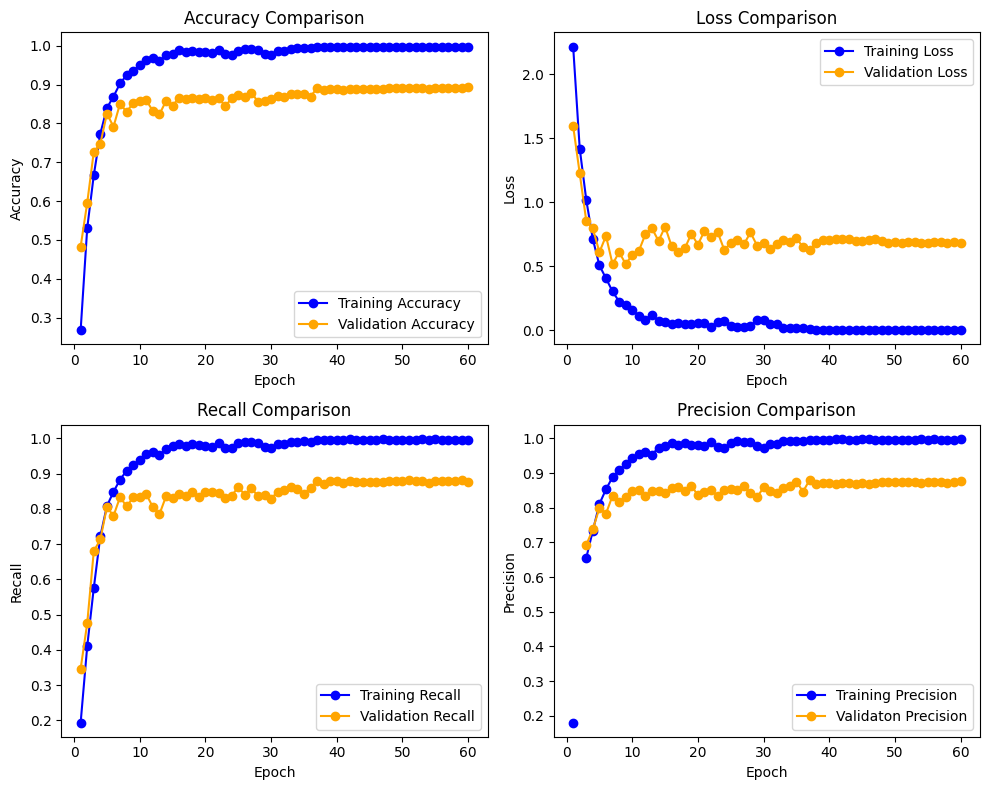

In [11]:
epochs = range(1, EPOCHS + 1)
# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Plot accuracy
axs[0, 0].plot(epochs, train_accuracy_list, label = 'Training Accuracy', color='blue', marker='o')
axs[0, 0].plot(epochs, val_accuracy_list, label='Validation Accuracy', color='orange', marker='o')
axs[0, 0].set_title('Accuracy Comparison')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].legend()

# Plot loss
axs[0, 1].plot(epochs, train_loss_list, label = 'Training Loss', color='blue', marker='o')
axs[0, 1].plot(epochs, val_loss_list, label='Validation Loss', color='orange', marker='o')
axs[0, 1].set_title('Loss Comparison')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend()

# Plot recall
axs[1, 0].plot(epochs, train_recall_list, label = 'Training Recall', color='blue', marker='o')
axs[1, 0].plot(epochs, val_recall_list, label= 'Validation Recall', color='orange', marker='o')
axs[1, 0].set_title('Recall Comparison')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Recall')
axs[1, 0].legend()

# Plot precision
axs[1, 1].plot(epochs, train_precision_list, label = 'Training Precision', color='blue', marker='o')
axs[1, 1].plot(epochs, val_precision_list, label='Validaton Precision', color='orange', marker='o')
axs[1, 1].set_title('Precision Comparison')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Precision')
axs[1, 1].legend()

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()